# P07 : Impélanter un modèle de scoring : notebook de Modélisation

- **1.Importer les librairies utiles & télécharger les données** 

- **2.Préparation des données pour la modélisation**

    - 2.1.Séparation de données  en train et test**
    - 2.2. Standardisation des données 
- **3.Modélisation des données avant traiter le problème de classification déséquilibrée**
    - 3.1.Définition des fonctions pour comparer les algorithmes
    - 3.2.Comparer les algorithmes
- **4.Sélectionner le modèle**
- **5.Métrique spécifique pour la classification déséquilibrée**
- **6.Technique de rééchantillonnage : SMOTE**
    - 6.1 Optimisation des hyperparamètres avec validation croisée pour obtenir le meilleur score 
    - 6.2 Trouver le seuil optimal	
		- 6.2.1 Seuil optimal pour ROC curve
		- 6.2.2 Seuil optimal pour Precision-Recall curve
- **7.Traiter le problème de classification déséquilibrée avec « Class_weight »**
	- 7.1 . Optimisation des hyperparamètres avec validation croisée pour obtenir le meilleur score 
	- 7.2 Trouver le seuil optimal 
		- 7.2.1 Seuil optimal pour ROC curve
		- 7.2.2 Seuil optimal pour Precision-Recall curve

- **8. Comparer les modèles** 
- **9. Enregistrer le modèle sur le disque**
- **10. Interprétabilité du modèle** 
    - 10.1 Interprétabilité globale : feature importance 
	- 10.2  Interprétabilité locale : « shaply values » 

# 1. Importer les librairies & télécharger les donnée pour la modélisation 

In [1]:
import pandas as pd 
import numpy as np 
from numpy import argmax
from numpy import sqrt
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from matplotlib import pyplot
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import time

import os

# Modèles de ML

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier


# Transformations de variables
from sklearn.preprocessing import StandardScaler


#Evaluation metrics for classification
from sklearn.metrics import  confusion_matrix, classification_report, roc_curve, make_scorer
from sklearn.metrics import auc, f1_score, recall_score, precision_score, fbeta_score, roc_auc_score,accuracy_score 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report


#To balance classes
import imblearn
from sklearn.utils import class_weight



## Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 


## HyperOpt functions
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial


# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, StratifiedKFold,GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import ParameterSampler

#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval


#Local interpretability

import shap


# Save model
import pickle
import joblib

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Set colors pour afficher
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'  

In [3]:
data = pd.read_csv(r"C:\Users\faeze\OneDrive\Documents\OC data science\PROJECT\Projet 7\data_final.csv")

In [4]:
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
0,100002,1.0,0,0,0,406597.5,24700.5,0.018801,9461,637.0,...,2.0,20.421053,388.0,0.000,0.000000,0.000,11559.247105,219625.695,9251.775,5993.0
1,100003,0.0,1,0,0,1293502.5,35698.5,0.003541,16765,1188.0,...,2.0,7.160000,179.0,0.000,0.000000,0.000,64754.586000,1618864.650,6662.970,34633.0
2,100004,0.0,0,1,0,135000.0,6750.0,0.010032,19046,225.0,...,2.0,7.666667,23.0,0.000,0.000000,0.000,7096.155000,21288.465,5357.250,2285.0
3,100006,0.0,1,0,0,312682.5,29686.5,0.008019,19005,3039.0,...,2.0,19.375000,310.0,0.000,0.000000,0.000,62947.088438,1007153.415,2482.920,4346.0
4,100007,0.0,0,0,0,513000.0,21865.5,0.028663,19932,3038.0,...,2.0,4.590909,303.0,22655.655,452.384318,29857.365,12666.444545,835985.340,0.180,68128.0


In [5]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
# Id customer as index
data_final = data.set_index('SK_ID_CURR')

In [7]:
# Check the duplicate
data_final = data_final.loc[:,~data_final.columns.duplicated()]

In [8]:

len(data_final[data_final['TARGET']==1])/len(data_final[data_final['TARGET']==0])

0.0749035983899875

# 2. Préparation des données pour la modélisation

## 2.1 séparation de données  en train et test 

In [9]:
train_set, test_set = train_test_split(data_final, train_size=0.8, stratify=data_final['TARGET'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print('The shape of train :', train_set.shape)
print(Counter(train_set['TARGET']))
print('\nThe shape of test :', test_set.shape)
print(Counter(test_set['TARGET']))

The shape of train : (285000, 171)
Counter({0.0: 265140, 1.0: 19860})

The shape of test : (71251, 171)
Counter({0.0: 66286, 1.0: 4965})


## 2.2 La standardisation des données 

In [10]:
# Select colomns for preprocessing 
columns_to_scale = []
for col in data_final.columns:
    if (data_final[col].max()>10) | (data_final[col].min()<-10) :
        columns_to_scale.append(col)
        
len(columns_to_scale)  

56

In [11]:
def preprocessing(df, flag_train = True):

    X = df.drop(columns=['TARGET'],axis=1)
    y = df['TARGET'].values
    print(Counter(y))
        
    scaler = StandardScaler()
    if flag_train :
        X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
                
    else:
        scaler.fit_transform(train_set[columns_to_scale])
        X[columns_to_scale] = scaler.transform(X[columns_to_scale])    
    return X.values, y
   

In [12]:
X_train, y_train = preprocessing(train_set, flag_train=True)
X_test, y_test = preprocessing(test_set, flag_train=False)

Counter({0.0: 265140, 1.0: 19860})
Counter({0.0: 66286, 1.0: 4965})


# 3. Modélisation des données avant traiter le problème de classification déséquilibrée 
## 3.1. Définition des functions pour comparer les algorithmes

In [13]:
# Séparer les données d'entraînement pour la validation croisée 
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [14]:
def plot_roc_curve(classifiers, x,y) : 
    
    """
    To compare roc_auc score for different classifeier in order to choose the best of them
    """
    
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls.fit(x, y)
        yproba = model.predict_proba(X_test)[:,1]
    
        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)
    
        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    result_table.sort_values(by='auc', ascending=False, inplace=True)
    
    fig = plt.figure(figsize=(8,8))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']
                                          
                                          
                                          ))
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [15]:
def learn_curve(model, x, y):
    
    """To plot learn curve to study overfitting and underfitting phenomena"""
    
    N, train_score, val_score = learning_curve(
        model,
        x,
        y,
        cv=cv,
        train_sizes=np.linspace(0.1,1,10), 
        scoring= 'roc_auc'
    )
    
    plt.figure (figsize= (8,5))
    plt.title (label=model)
    plt.plot(N , train_score.mean (axis=1) , label = "train_score")
    plt.plot(N , val_score.mean (axis=1) , label = "validation_score")
    plt.xlabel ("training samples")
    plt.ylabel ("score")
    #plt.ylim(0,1)
    plt.legend ()
    plt.show ()

#####################################################################################################################

def train_models(model,x,y):
    
    """
    To train model and calculate its performance metrics
    """
    model.fit(x,y)
    output = {
      'ROC_AUC'  : roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy' : accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall'   : recall_score(y_test, model.predict(X_test)),
      'F1'       : f1_score(y_test, model.predict(X_test)),
      'Fbeata_score'       : fbeta_score(y_test, model.predict(X_test), beta=5)
      }
          
    return output

#####################################################################################################################

def resume_score(classifiers, x, y):
    
    """ 
    To compare several models in a table that shows some metric as well as fit time
    """

    name = []
    auc = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    f5 = []
    time_ = []
 
    for model in classifiers:
        start = time.time()
        results = train_models(model, x,y)

        name.append(type(model).__name__)
        auc.append(results['ROC_AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        f5.append(results['Fbeata_score'])
        time_.append(time.time()-start)
 
    #Initialise data of lists
    base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, f5, time_]).T
    base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'F5', 'Time']
    base_models.sort_values('AUC', ascending=False, inplace=True)
    return base_models


In [16]:
def cf_matrix_roc_auc(x, y, model):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Reds")

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.legend()
    plt.show()

In [17]:
# List of models
default_models = [
    DummyClassifier(strategy='most_frequent', random_state=1),
    LogisticRegression(random_state=1), 
    RandomForestClassifier(random_state=1),
    LGBMClassifier(random_state=1),
   # SVC(random_state=1, probability=True),
    #XGBClassifier(random_state=1)
]
   #KNeighborsClassifier(),
    #AdaBoostClassifier(random_state=1),
   # GradientBoostingClassifier(random_state=1), 

## 3.2.	Comparer les algorithmes 

In [18]:
# To compare models
resume_score(default_models, X_train, y_train)

,Model,AUC,Accuracy,Precision,Recall,F1,F5,Time
3,LGBMClassifier,0.776617,0.930569,0.534884,0.027795,0.052843,0.028846,16.118997
1,LogisticRegression,0.760524,0.930219,0.475862,0.013897,0.027006,0.014436,9.132076
2,RandomForestClassifier,0.721412,0.930401,0.75,0.001813,0.003617,0.001885,666.279387
0,DummyClassifier,0.5,0.930317,0.0,0.0,0.0,0.0,0.366904


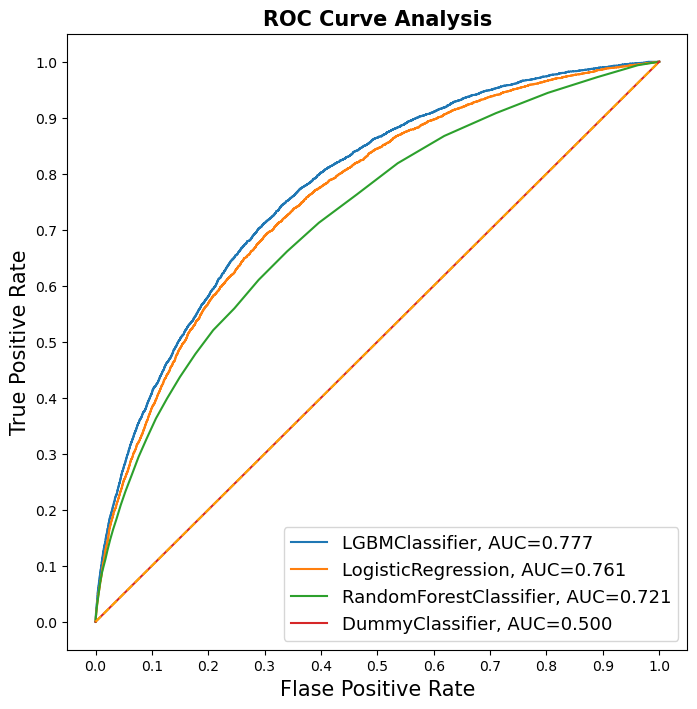

In [19]:
plot_roc_curve(default_models, X_train, y_train)

DummyClassifier


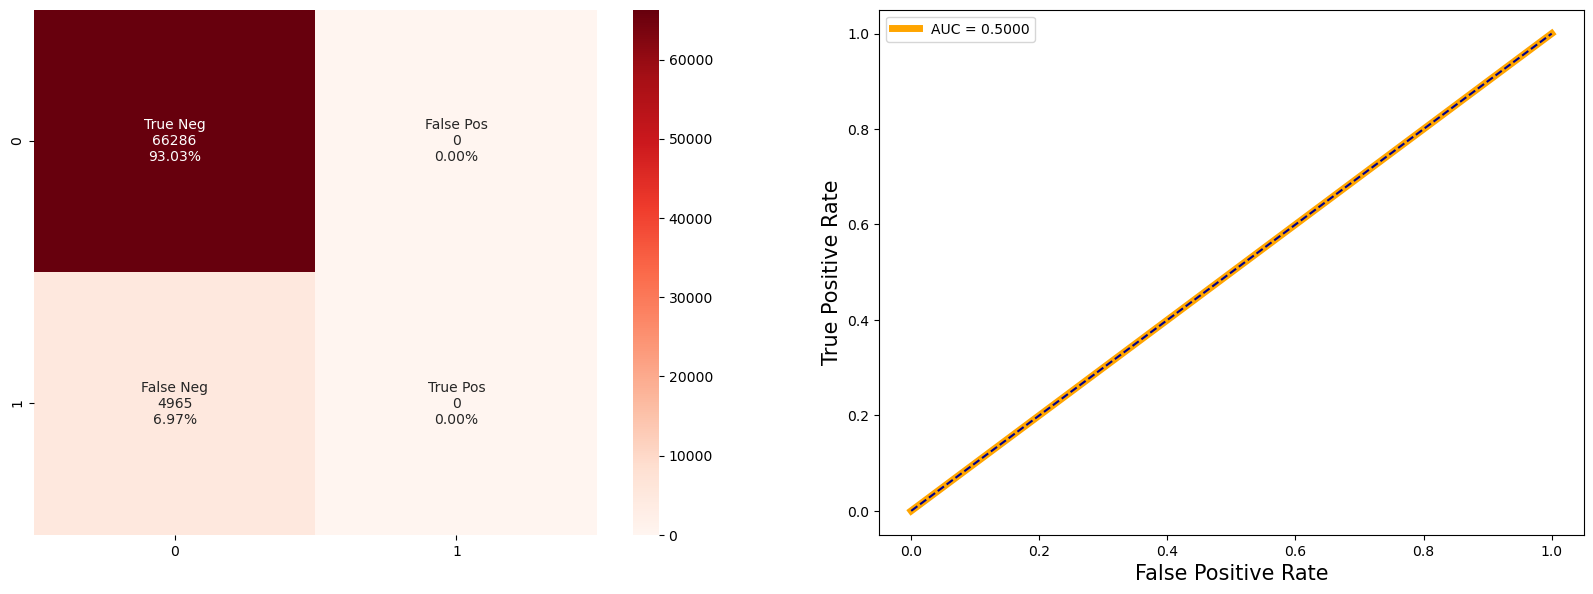

LogisticRegression


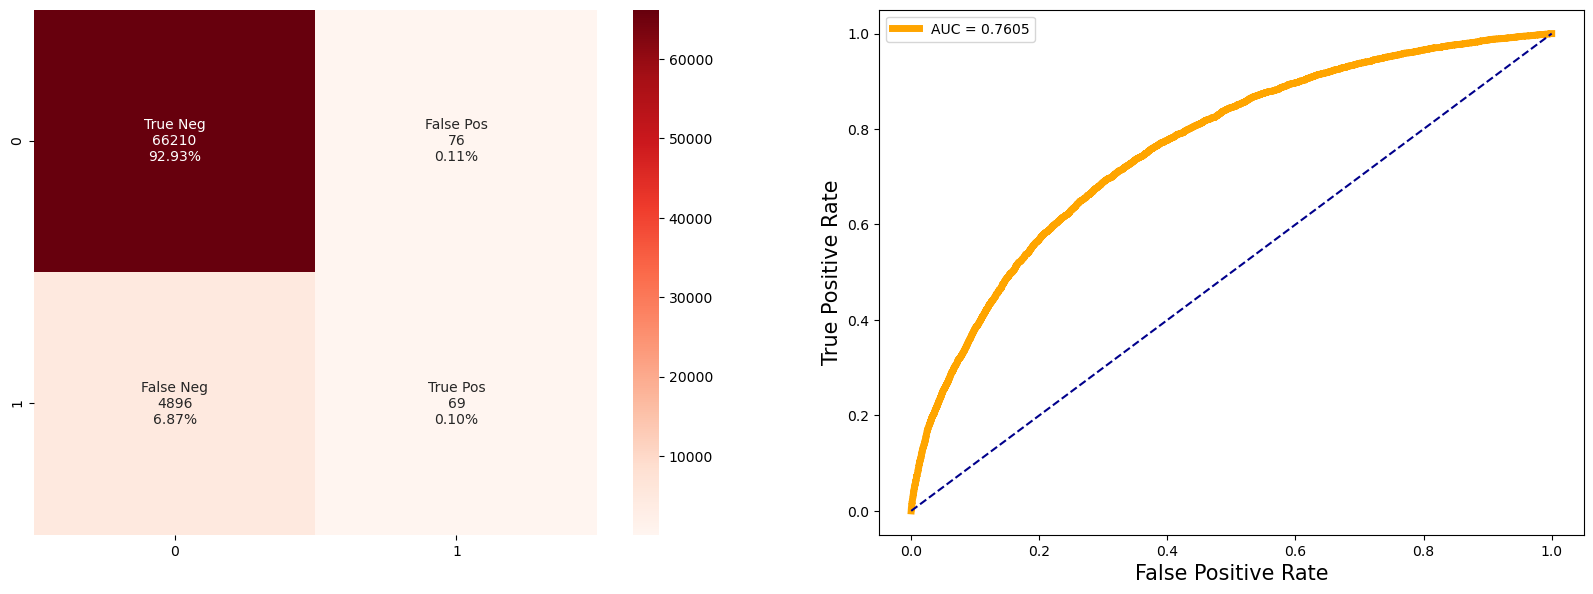

RandomForestClassifier


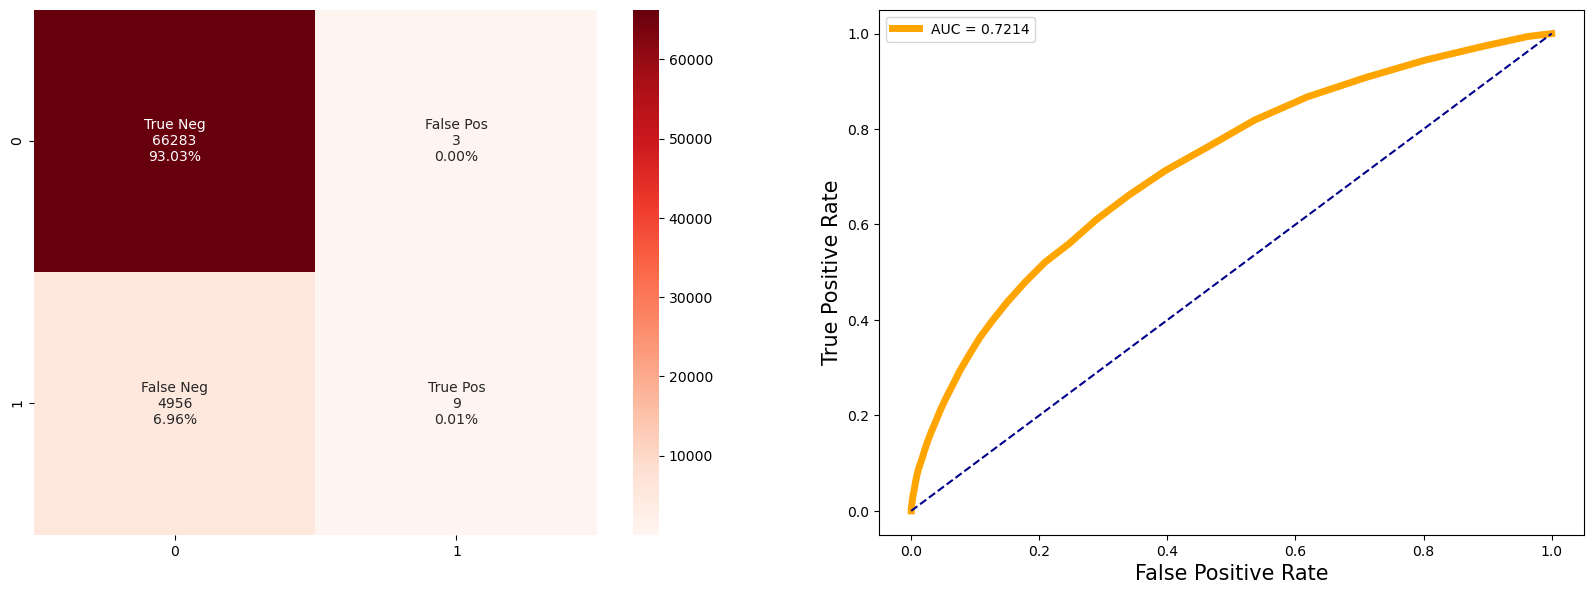

LGBMClassifier


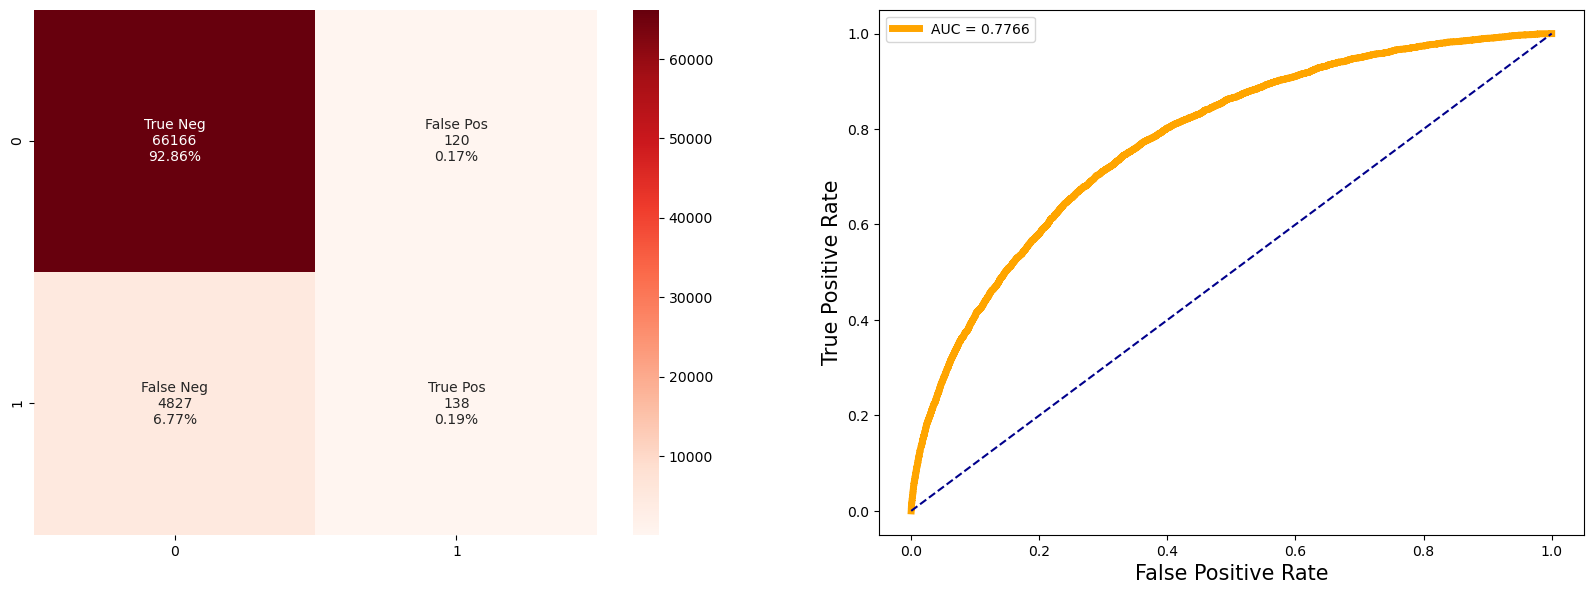

In [20]:
# Clissification report for each model
for model in default_models :
    print(type(model).__name__)
    cf_matrix_roc_auc(X_train, y_train, model)


- La classe des clinet qui ne rembourse pas le prêt sont considéré comme la classe positive et celle des client qui n'ont pas de difficulté de rembourser le prêt comme la classe négative. 
-  Les faux négatif ne sont pas acceptable  
-  On constate que le métrique  "rappel" est faible pour la classe minoritaire (la classe 1 ). Cela est du au fait que les  données sont déséquilibrées


-  On choisit l'algorithme LGBMClassifier, car elle a en meme temsp le meilleurs AUC_ROC(technic score), F5 (business score) et le temps d'entraînement. 
- Nous allons optimiser le modèle en essayant d'ajuster les hyperparamètres. 

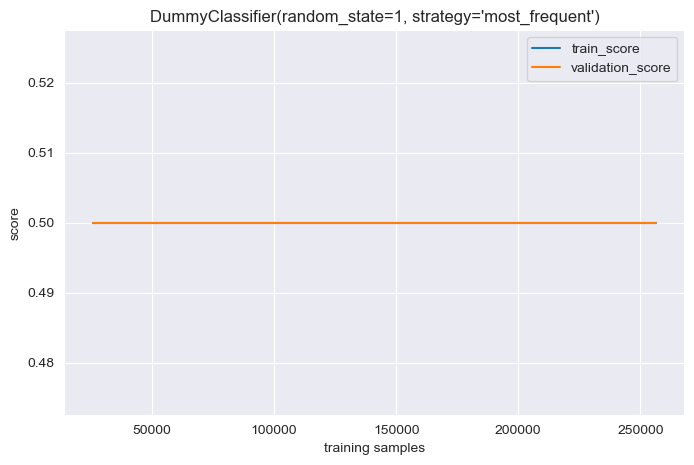

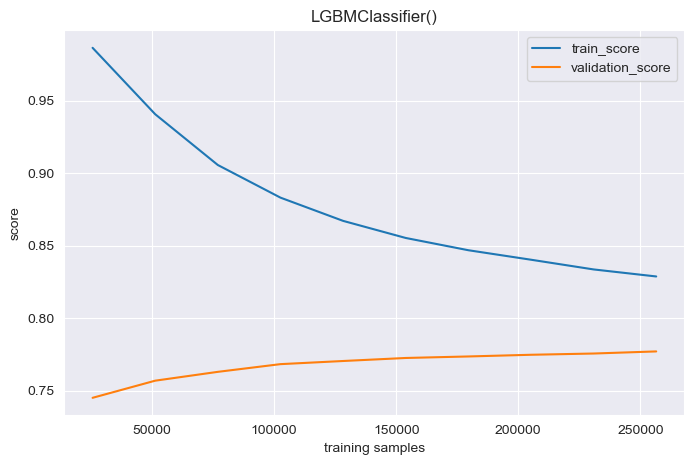

CPU times: total: 42min 5s
Wall time: 7min 14s


In [24]:
%%time

models_for_curve = [
    DummyClassifier(strategy='most_frequent', random_state=1),
    LGBMClassifier()
]  
for model in models_for_curve : 
    learn_curve(model, X_train, y_train)

- On remarque que le surajustement est très important (mauvaise chose). 
- Cela est probablement dû au déséquilibre de classe dans la cible. Dans la suite, nous allons essayer d'équilibrer ces classes et de chercher à nouveau les meilleurs hyperparamètres.
- **Le problème de overfitting à cause de donées déséquilibrées de TARGET**

# 4. Sélectionner l'algorithme 

Metrics :
 {'ROC_AUC': 0.7790325629434706, 'Accuracy': 0.9301062441228896, 'Precision': 0.4660633484162896, 'Recall': 0.020745216515609264, 'F1': 0.039722329348245274, 'Fbeata_score': 0.02153667990928538}
Classification report
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     66286
         1.0       0.47      0.02      0.04      4965

    accuracy                           0.93     71251
   macro avg       0.70      0.51      0.50     71251
weighted avg       0.90      0.93      0.90     71251



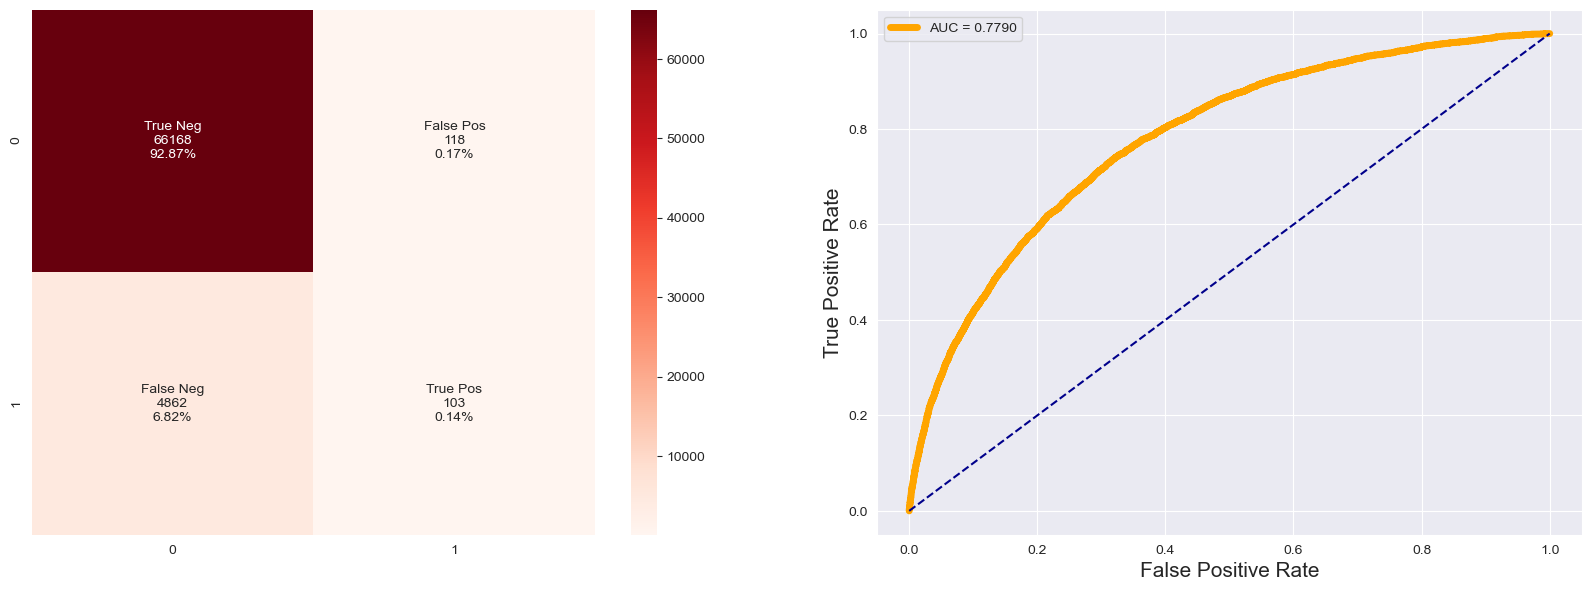

In [25]:
lg= LGBMClassifier(random_state=1)
lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_proba = lg.predict_proba(X_test)

y_positive = y_proba[:,1]
y_negative = y_proba[:,0]
print(color.BOLD + color.RED + "Metrics :\n"+ color.END,train_models(lg,X_train,y_train))
print(color.BOLD + color.GREEN + "Classification report\n"+ color.END,classification_report(y_test,y_pred))
cf_matrix_roc_auc(X_train, y_train, lg)

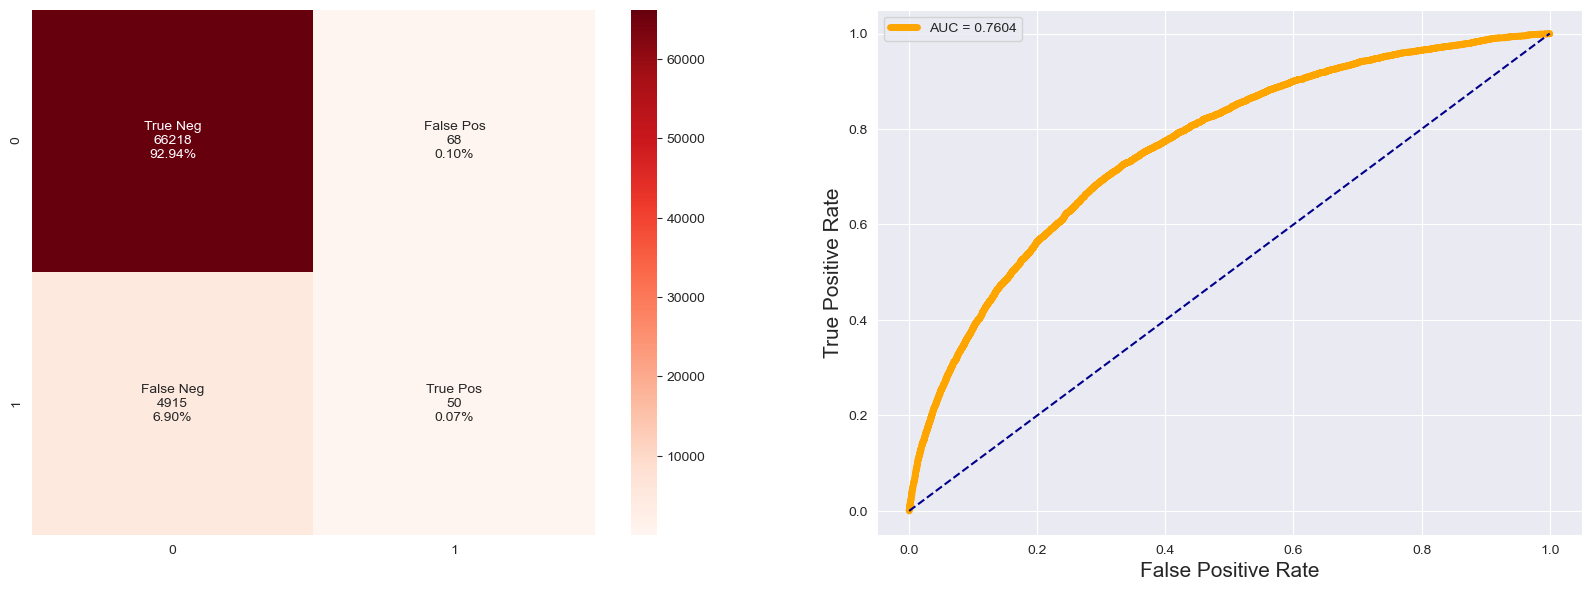

In [26]:
rg= LogisticRegression(random_state=1)
rg= rg.fit(X_train, y_train)
cf_matrix_roc_auc(X_train, y_train, rg)

# 5.Métrique spécifique pour la classification déséquilibrée

- **Comment mesurer la performance de son algorithme pour un problème de classification déséquilibrée?**  
- L'un des problèmes pour traiter des donnnées déséquilibrés est choisir les métriques pour évaluer leur modèle.
- L'utilisation de mesures plus simples comme le "Precision" ou "Accuracy" peut être trompeuse.
- Dans un jeu de données avec des classes très déséquilibrées, le classificateur "prédira" toujours la classe la plus courante sans effectuer aucune analyse des caractéristiques et il aura un taux de précision élevé, qui n'est pas pertinent.

- **Les métriques sont plus pertinentes dans le cas du déséquilibre de classes sont**: 
  - La précision pour minimiser le taux d’erreurs parmi les exemples prédits positifs par le modèle
  - Le rappel pour tenter de détecter un maximum de positif
  - Le F1-score pour trouver un compromis entre la précision et le rappel. Lorsqu’il est aussi coûteux de manquer un positif que de déclarer un faux positif

On ajuste les paramètre de l'estimator 'LGBM' en fonction de deux métriques : AUC_ROC (metric technic); F5score (metric buisness)

In [27]:
def search_best_score(model , x,y, params, business_metric=True, grid=True):

    """
    To find best paramaeters for the model to get the highets auc_roc score(technic score) or F5 score (business score)
    """
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    if grid : 
        if business_metric : 
            print(color.BOLD + color.BLUE +'F5 score...'+ color.END)
            f5_score = make_scorer(fbeta_score, beta=5)
            search = GridSearchCV(model, params, scoring=f5_score, cv=cv)
      
        else :
            print(color.BOLD + color.RED +'AUC_ROC score...'+ color.END)
            search = GridSearchCV(model, params, scoring='roc_auc', cv=cv)
  
       
    else :
        if business_metric : 
            print(color.BOLD + color.BLUE +'F5 score...'+ color.END)
            f5_score = make_scorer(fbeta_score, beta=5)
            search = RandomizedSearchCV(model, params, scoring=f5_score, cv=cv)
      
        else :
            print(color.BOLD + color.RED +'AUC_ROC score...'+ color.END)
            search = RandomizedSearchCV(model, params, scoring='roc_auc', cv=cv)
        
         # To train model
    search.fit(x, y) 
    print(model) 
    print('best parameters are:', search.best_params_)
    print
    print ("Train score : %.4f"% search.best_estimator_.score(x,y))
    print ("Best (validation) score is : %.4f"% search.best_score_)
    print ("Test score :%.4f"%search.best_estimator_.score(X_test , y_test)) 
    print("\n")
           
    return search.best_estimator_

# 6.Technique de rééchantillonnage : SMOTE 

- Une technique largement adoptée pour traiter des ensembles de données très déséquilibrés est appelée rééchantillonnage. 
- Elle consiste à retirer des échantillons de la classe majoritaire (sous-échantillonnage) et/ou à ajouter d'autres exemples de la classe minoritaire (sur-échantillonnage).
- On utilise SMOTE(Synthetic Minority Oversampling Technique)pour suréchantillonner la classe minoritaire (prêts non remboursés, cible = 1) 

In [28]:
smote = SMOTE(sampling_strategy='minority',random_state=12345)

In [29]:
def resampling(features, target, resample):
    print('Original dataset shape %s' % Counter(target))
    X, y = resample.fit_resample(features, target)
    print('Resampled dataset shape %s' % Counter(y))
    return X, y

In [30]:
X_train_sm,y_train_sm = resampling(X_train, y_train, smote)

Original dataset shape Counter({0.0: 265140, 1.0: 19860})
Resampled dataset shape Counter({0.0: 265140, 1.0: 265140})


In [31]:
print("Initial data nb lines:" ,{X_train.shape[0]})
print(f"Balanced data nb lines:" ,{X_train_sm.shape[0]})

Initial data nb lines: {285000}
Balanced data nb lines: {530280}


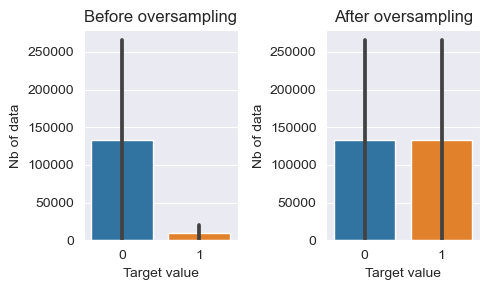

In [32]:
before = Counter(y_train)
after = Counter(y_train_sm)

df_before = pd.DataFrame.from_dict(before, orient='index').reset_index()

df_before = df_before.T

df_after = pd.DataFrame.from_dict(after, orient='index').reset_index()
df_after = df_after.T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

sns.set_style("darkgrid")
sns.barplot(ax=ax1, data=df_before)
ax1.set_xlabel("Target value")
ax1.set_ylabel("Nb of data")
ax1.set_title("Before oversampling")

sns.barplot(ax=ax2, data=df_after)
ax2.set_xlabel("Target value")
ax2.set_ylabel("Nb of data")
ax2.set_title("After oversampling")
plt.tight_layout()

## 6.1 Optimisation des hyperparamètres pour obtenir le meilleur score 

In [33]:
param_distributions = {
                       'max_depth' : [3],
                       'num_leaves': range(2,10),
                       #'learning_rate' : [0.01, 0.03]
                        #'colsample_bytree': [0.01, 0.1,0.2,0.3],
                        #'min_child_samples': [10,20,50],
                        #'min_child_weight':[5,10,20],                        
             
    #'reg_lambda':[10,50,70,100],
                        #'scale_pos_weight':[6,7,8,10,11,12,15,17],
}

In [34]:
best_buisness_model_smote = search_best_score(lg ,
                                              X_train_sm, y_train_sm, 
                                              param_distributions,
                                    business_metric=True, grid=True)

F5 score...
LGBMClassifier(random_state=1)
best parameters are: {'max_depth': 3, 'num_leaves': 8}
Train score : 0.9561
Best (validation) score is : 0.9196
Test score :0.9283




In [35]:
best_technic_model_smote = search_best_score(lg,X_train_sm, y_train_sm , param_distributions,
                                             business_metric=False, grid=True)               

AUC_ROC score...
LGBMClassifier(random_state=1)
best parameters are: {'max_depth': 3, 'num_leaves': 8}
Train score : 0.9561
Best (validation) score is : 0.9781
Test score :0.9283




Classification report:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     66286
         1.0       0.31      0.02      0.04      4965

    accuracy                           0.93     71251
   macro avg       0.62      0.51      0.50     71251
weighted avg       0.89      0.93      0.90     71251



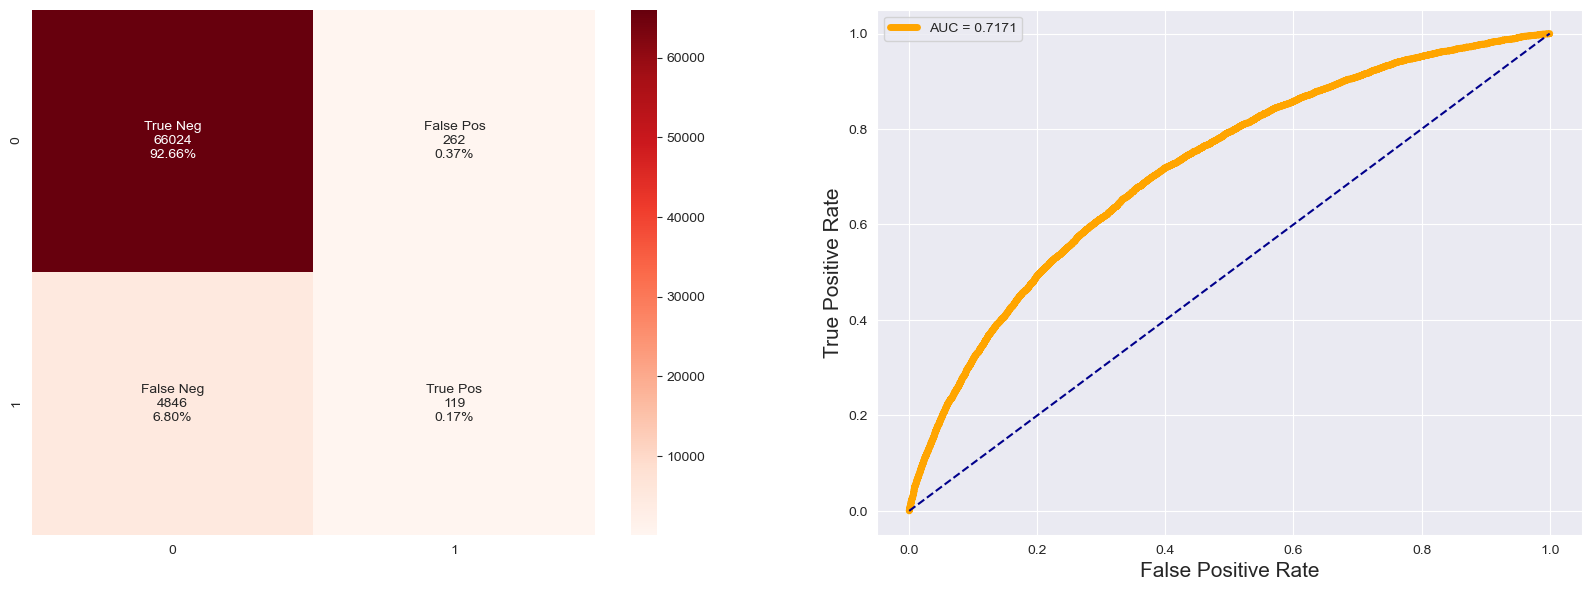

Metrics :
 {'ROC_AUC': 0.7171015607882337, 'Accuracy': 0.9283097781083774, 'Precision': 0.3123359580052493, 'Recall': 0.023967774420946625, 'F1': 0.04451926674148896, 'Fbeata_score': 0.024850208022103353}


In [36]:
lgbm_smote = best_buisness_model_smote.fit(X_train_sm,y_train_sm)
y_pred_smote = lgbm_smote.predict(X_test)

yhat = lgbm_smote.predict_proba(X_test)

yhat_positive = yhat[:,1]
yhat_negative = yhat[:,0]
print(color.BOLD + color.CYAN + "Classification report:\n"+ color.END,classification_report(y_test,y_pred_smote))
cf_matrix_roc_auc(X_train_sm, y_train_sm, lgbm_smote )
print(color.BOLD + color.BLUE + "Metrics :\n"+ color.END,train_models(lgbm_smote,X_train_sm,y_train_sm))

[Text(0, 0.5, 'Predict Positive:1'), Text(0, 1.5, 'Predict Negative:0')]

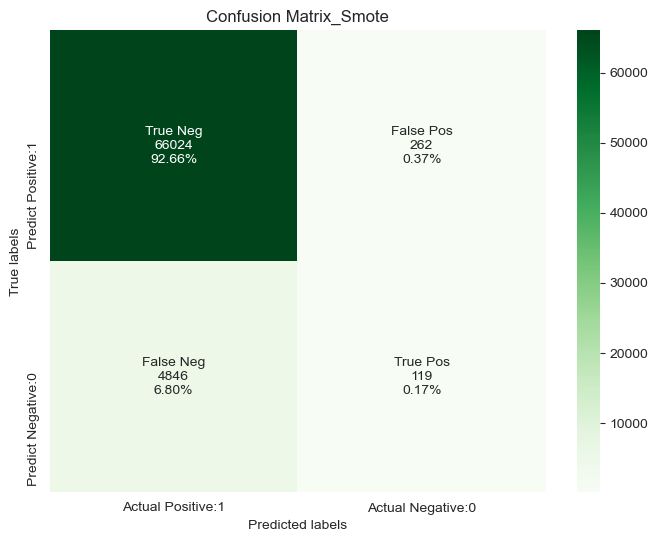

In [39]:
cm_sm = confusion_matrix(y_test,y_pred_smote)
names = ['True Neg','False Pos','False Neg','True Pos']
counts = ["{0:0.0f}".format(value) for value in
                cm_sm.flatten()]
percentages = ["{0:.2%}".format(value) for value in
                     cm_sm.flatten()/np.sum(cm_sm)]
lbls = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(names,counts,percentages)]
lbls = np.asarray(lbls).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_sm, annot=lbls, fmt='', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_Smote')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])

**Precision : comment le modèle a prédit la classe positif **

## 6.2 Trouver le seuil optimal

### 6.2.1 Seuil optimal pour ROC Curve

- **Il existe deux méthode pour trouver le seuil optimal entre les taux de faux positifs et de true positifs.
- 1. G-Mean = sqrt(Sensitivity * Specificity)
    - **Sensitivity = Sensitivity = TP /(TP+FN)**
    - **Specificity = Specificity = TN /(TN+FP)** 


- 2. Youden’s J statist
    - J = TruePositiveRate – FalsePositiveRate
    - Le meuiller seuil est la plus grande valeur de J statistic

In [40]:
# Trouver le meuiller seuil pour Youden's J statistic
def tune_threshold_j(true_labels, predicted_probas):
    fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)

    return threshold[index_for_best_threshold], index_for_best_threshold

def tune_thresholds_pr_curve(true_lables, predicted_probas) :
    precision, recall, threshold = precision_recall_curve(true_lables, predicted_probas)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
   
    return threshold[ix], fscore[ix], ix



def proba_to_class(proba, threshold):
     return np.where(proba >= threshold, 1, 0)
    
# Annoter le seuil optimal AUC
def annot_auc(x,y, ax=None):
    plt.annotate("{:.3f}".format(y), xy=(x, y), xytext=(x*2, y/2), fontsize=12,
                     bbox=dict(facecolor='white', fc ="0.99", edgecolor='black', boxstyle='round'),
                     arrowprops=dict(arrowstyle = "->",connectionstyle = "angle,angleA=90,angleB=180,rad=0",color='black')
                     )

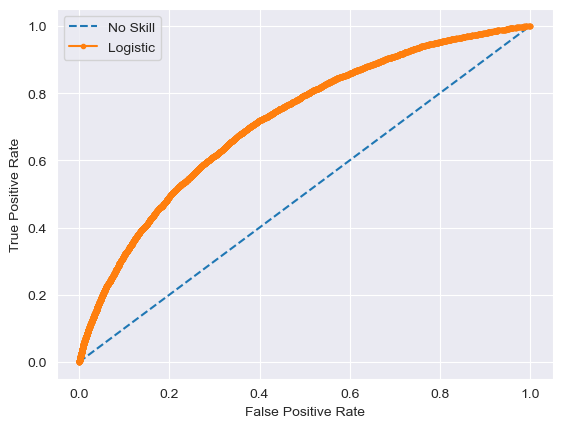

In [41]:
fpr_s, tpr_s, thresholds_s = roc_curve(y_test, yhat_positive)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_s, tpr_s, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.150188, G-Mean=0.660


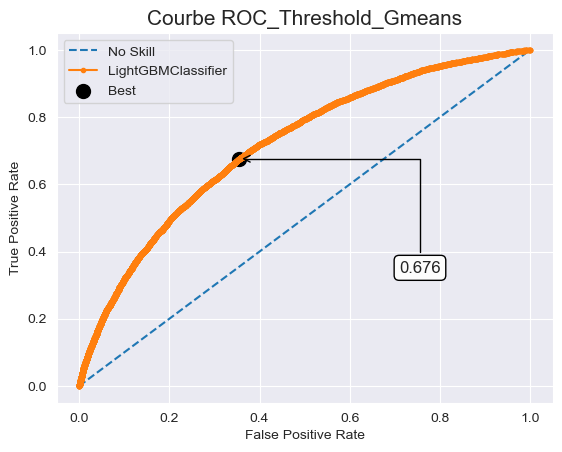

In [42]:
# calculer le G-Means
gmeans = sqrt(tpr_s * (1-fpr_s))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_s[ix], gmeans[ix]))

# plot  roc curve
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_s, tpr_s, marker='.', label='LightGBMClassifier')
pyplot.scatter(fpr_s[ix], tpr_s[ix], marker='o', color='black', label='Best',s=100)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

plt.title('Courbe ROC_Threshold_Gmeans', fontsize= 15)
annot_auc(fpr_s[ix], tpr_s[ix])

# show the plot
pyplot.show()

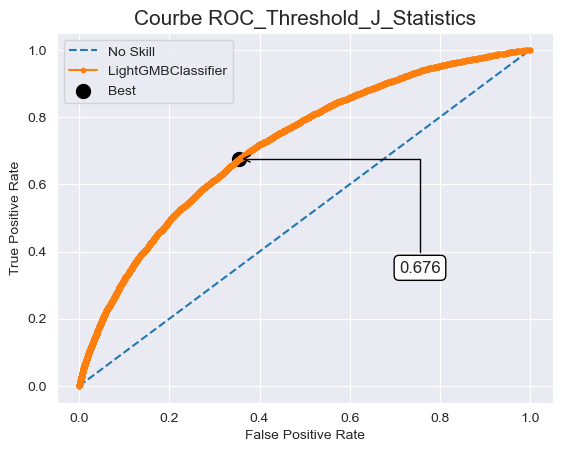

In [43]:
best_threshold_t, index = tune_threshold_j(y_test, yhat_positive)


# plot roc curve 
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_s, tpr_s, marker='.', label='LightGMBClassifier')
pyplot.scatter(fpr_s[index], tpr_s[index], marker='o', color='black', label='Best',s=100)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

plt.title('Courbe ROC_Threshold_J_Statistics', fontsize= 15)
annot_auc(fpr_s[index], tpr_s[index])

# show the plot
pyplot.show()

### 6.2.2 Seuil optimal pour Precision-Recall curve 


**"Precision-recall curve" focalise seulement sur la class positive

    - **Precision= TP /(TP+FP)**
    - **Recall= TP /(TP+FN)**

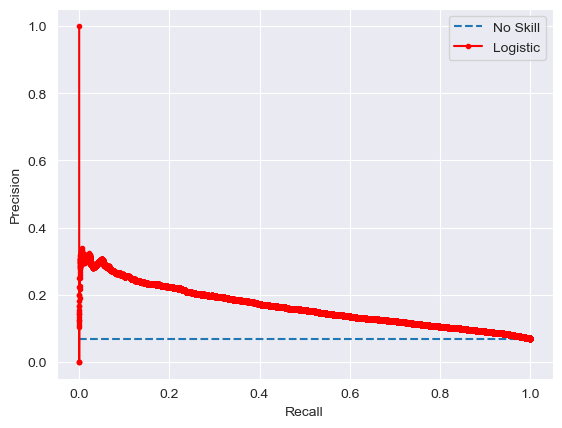

In [44]:
#calculate pr_curve
precision2, recall2, thresholds_2 = precision_recall_curve(y_test, yhat_positive)

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall2, precision2, marker='.', label='Logistic', color = 'r')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

- on s'intéresse  à un seuil qui donne le meilleur équilibre entre précision et rappel car on cherche un modèle avec un meiller f_score  : 

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [45]:
best_threshold_pr_curve,best_f, index_pr = tune_thresholds_pr_curve(y_test, yhat_positive)

print('Best Threshold_PR_curve=%f' %(best_threshold_pr_curve))

Best Threshold_PR_curve=0.679349


[Text(0, 0.5, 'Predict Positive:1'), Text(0, 1.5, 'Predict Negative:0')]

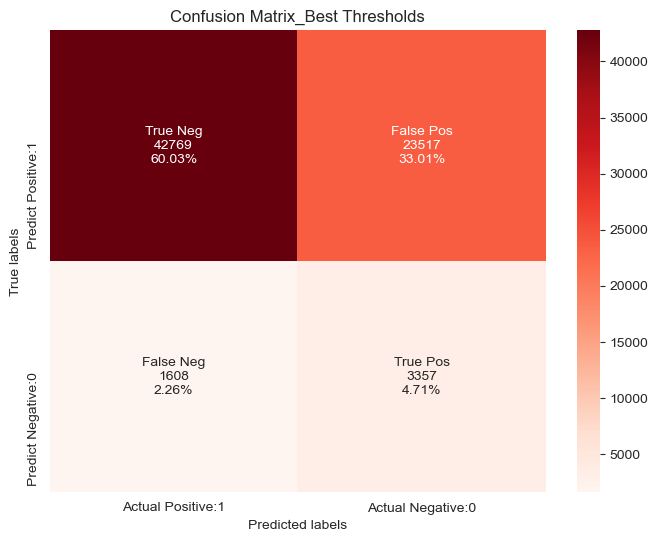

In [46]:
thresh_roc = proba_to_class(yhat_positive, best_threshold_t)

cm_smote = confusion_matrix(y_test,thresh_roc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_smote.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_smote.flatten()/np.sum(cm_smote)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_smote, annot=labels, fmt='', cmap='Reds')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_Best Thresholds')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])

In [47]:
print('ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, thresh_roc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, thresh_roc)))
print('recall score: {0:0.4f}'.format(recall_score(y_test, thresh_roc)))
print('F_measure: {0:0.4f}'.format(f1_score(y_test, thresh_roc)))
print('Fbeta-measure: {0:0.4f}'.format(fbeta_score(y_test, thresh_roc, beta =5)))

ROCAUC score: 0.6607
Precision score: 0.1249
recall score: 0.6761
F_measure: 0.2109
Fbeta-measure: 0.5780


In [48]:
print(color.BOLD + color.BLUE +'Classification Report_SMOTE'+ color.END)
print(classification_report(y_test, thresh_roc))

Classification Report_SMOTE
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.77     66286
         1.0       0.12      0.68      0.21      4965

    accuracy                           0.65     71251
   macro avg       0.54      0.66      0.49     71251
weighted avg       0.91      0.65      0.73     71251



# 7.Traiter le problème de classification déséquilibrée avec « Class_weight » 

In [49]:
print('class weihgts are :',class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train))  
lgbm = LGBMClassifier(class_weight='balanced', random_state=1)
log_reg = LogisticRegression(class_weight='balanced', random_state=1)

class weihgts are : [0.53745191 7.17522659]


##  7.1.Optimisation des hyperparamètres avec validation croisée pour obtenir le meilleur score

In [50]:
beta = 5
def cross_validate(classifier, X, y, beta=beta, flag_trade=True):
    
    
    train_score, val_score = [], []
    for train_idx, val_idx in cv.split(X,y) : 
        #X_res, y_res = SMOTE().fit_resample(X[train_idx], y[train_idx])
        X_res, y_res = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        f5_scorer = make_scorer(fbeta_score, beta=5)
        classifier.fit(X_res, y_res)
        
        if not flag_trade : 
            val_score.append(roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1]))
            train_score.append(roc_auc_score(y_res, classifier.predict_proba(X_res)[:,1]))
        else :
            val_score.append(fbeta_score(y_val, classifier.predict(X_val), beta=beta))
            train_score.append(fbeta_score(y_res, classifier.predict(X_res), beta=beta))
    return val_score, train_score    

def grid_search(classifier, params, X, y, flag_trade=True):
    val_best_score = 0
    param_list = list(ParameterSampler(params, random_state=1, n_iter=100))
    for param_grid in tqdm(param_list):
        classifier.set_params(**param_grid)
        val_score, train_score = cross_validate(classifier, X, y, beta, flag_trade=flag_trade)
        train_mean_score = np.array(train_score).mean()
        val_mean_score = np.array(val_score).mean()
        
        if val_mean_score > val_best_score : 
            val_best_score = val_mean_score
            best_estimator = classifier
            classifier.predict(X_test)
            test_score = fbeta_score(y_test, classifier.predict(X_test), beta=5)
    print(best_estimator)        
    print(' train score ', train_mean_score)
    print('\n val score', val_best_score)
    print('\n test score', test_score)
          
    return best_estimator, val_best_score, val_mean_score, train_mean_score
  

In [51]:
%%time
print('best results of LGBMClassifier with F5 score')
best_estimator_lgbm_business, val_best_score, val_mean_score, train_mean_score = grid_search(
    lgbm,
    param_distributions, 
    X_train,
    y_train,
    flag_trade=True
)

best results of LGBMClassifier with F5 score


100%|██████████| 8/8 [05:12<00:00, 39.02s/it]

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=9,
               random_state=1)
 train score  0.6225019399191657

 val score 0.6067840641290073

 test score 0.6071251080748049
CPU times: total: 32min 58s
Wall time: 5min 12s


In [52]:
%%time
print('best results of LGBMClassifier with ROC_AUC score')
best_estimator_lgbm_tech, val_best_score, val_mean_score, train_mean_score = grid_search(
    lgbm,
    param_distributions, 
    X_train,
    y_train,
    flag_trade=False)

best results of LGBMClassifier with ROC_AUC score


100%|██████████| 8/8 [05:35<00:00, 41.92s/it]

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=9,
               random_state=1)
 train score  0.7792862846014762

 val score 0.7666559804882954

 test score 0.6067250566546212
CPU times: total: 35min 56s
Wall time: 5min 35s


In [55]:
def best_class_weight(classifier): 
    
    """ 
    To optimize weight target classes of model
    """
    #Set the range of class weights
    weights = np.linspace(0,0.99,20)
    #Create dictionary grid for grid search
    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

    ##Fitting training data with 5 times grid search method
    f5_scorer = make_scorer(fbeta_score, beta=5)
    gridsearch = GridSearchCV(estimator= classifier, 
                          param_grid= param_grid,
                          cv=cv, 
                          n_jobs=-1, 
                          scoring = f5_scorer, 
                          verbose=2)
    
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    print ("Train score : %.4f"%gridsearch.best_estimator_.score(X_train, y_train))
    print ("Best (validation) score is : %.4f"%gridsearch.best_score_)
    print ("test score :%.4f"%gridsearch.best_estimator_.score(X_test , y_test))

    #Draw fractions with different weight values
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,8))
    weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
    sns.lineplot(weigh_data['weight'], weigh_data['score'])
    plt.xlabel('Weight for class 1')
    plt.ylabel('F5 score')
    plt.xticks([round(i/10,1) for i in range(0,11,1)])
    plt.title('Scoring for different class weights', fontsize=24)
    return gridsearch.best_params_

[Text(0, 0.5, 'Predict Positive:1'), Text(0, 1.5, 'Predict Negative:0')]

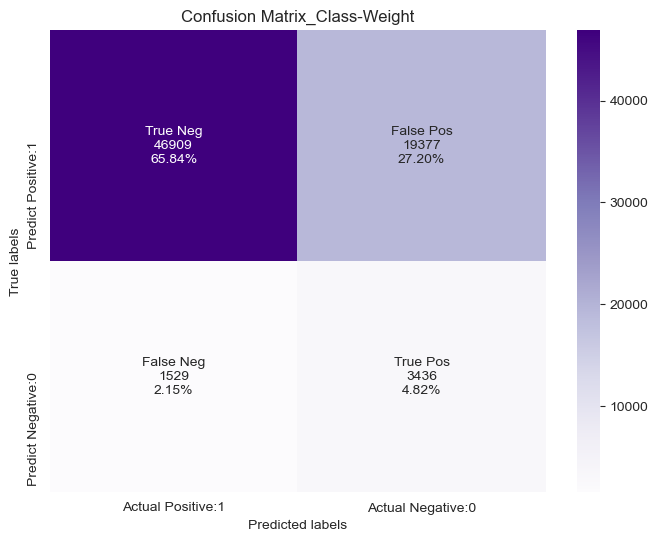

In [56]:
#Définir des modèle en équilibrant la classe
lgbm_balance = best_estimator_lgbm_business.fit(X_train, y_train)

y_pred_balance = lgbm_balance.predict(X_test)

yhat_balance = lgbm_balance.predict_proba(X_test)

yhat_balance_pos =  yhat_balance[:,1]
yhat_balance_neg = yhat_balance[:,0]

conf_b = confusion_matrix(y_test, y_pred_balance)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts_b = ["{0:0.0f}".format(value) for value in
                conf_b.flatten()]
group_percentages_b = ["{0:.2%}".format(value) for value in
                     conf_b.flatten()/np.sum(conf_b)]
labels_b = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts_b,group_percentages_b)]
labels_b = np.asarray(labels_b).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(conf_b, annot=labels_b, fmt='', cmap='Purples')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_Class-Weight')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])

In [57]:
print('ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, yhat_balance_pos)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test,y_pred_balance)))
print('Recall score: {0:0.4f}'.format(recall_score(y_test, y_pred_balance)))
print('F_measure: {0:0.4f}'.format(f1_score(y_test, y_pred_balance)))
print('Fbeta-measure: {0:0.4f}'.format(fbeta_score(y_test, y_pred_balance, beta =5)))


ROCAUC score: 0.7690
Precision score: 0.1506
Recall score: 0.6920
F_measure: 0.2474
Fbeta-measure: 0.6080


## 7.2 Trouver le seuil optimal 

### 7.2.1 Seuil optimal pour ROC curve 

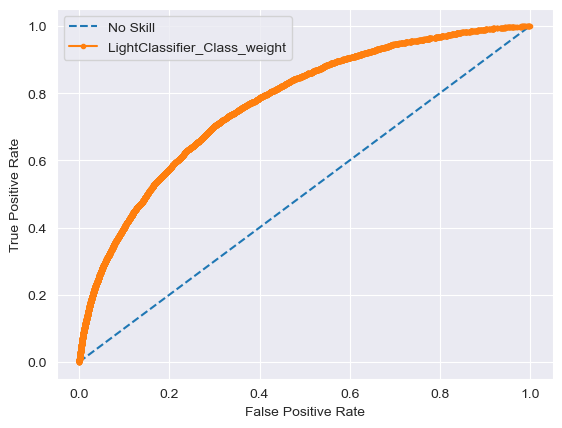

In [58]:
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, yhat_balance_pos)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_b, tpr_b, marker='.', label='LightClassifier_Class_weight')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [59]:

# calcuer le g-mean 
gmeans_b = sqrt(tpr_b * (1-fpr_b))

# localiser l'index de la plus granede valeur de g_means
ix_b = np.argmax(gmeans_b)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_b[ix_b], gmeans_b[ix_b]))


Best Threshold=0.494260, G-Mean=0.702


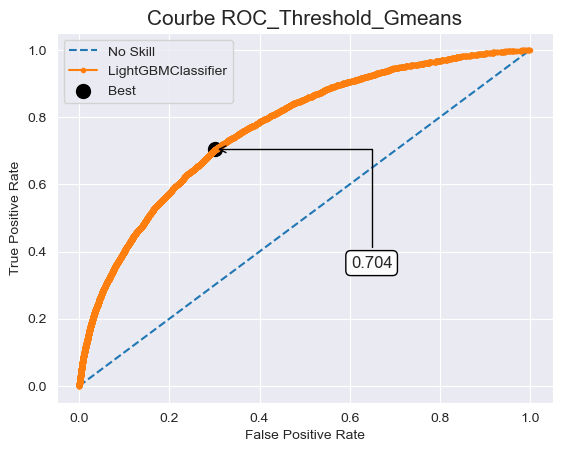

In [60]:
# plot roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_b, tpr_b, marker='.', label='LightGBMClassifier')
pyplot.scatter(fpr_b[ix_b], tpr_b[ix_b], marker='o', color='black', label='Best',s=100)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

plt.title('Courbe ROC_Threshold_Gmeans', fontsize= 15)
annot_auc(fpr_b[ix_b], tpr_b[ix_b])

# show the plot
pyplot.show()

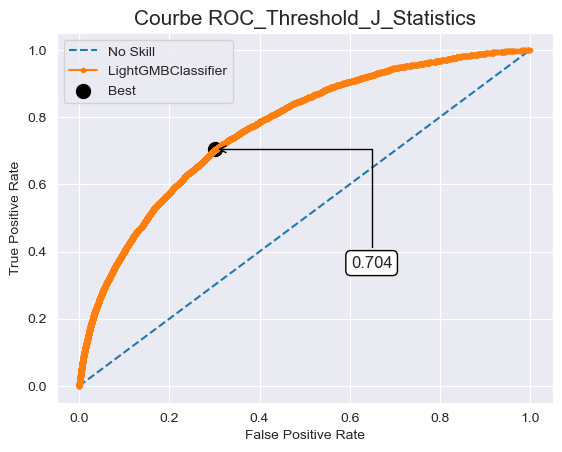

In [61]:
best_threshold_b, index_b = tune_threshold_j(y_test, yhat_balance_pos)


# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr_b, tpr_b, marker='.', label='LightGMBClassifier')
pyplot.scatter(fpr_b[index_b], tpr_b[index_b], marker='o', color='black', label='Best',s=100)
#label='AUC = %0.4f' %roc_auc
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

plt.title('Courbe ROC_Threshold_J_Statistics', fontsize= 15)
annot_auc(fpr_b[index_b], tpr_b[index_b])

# show the plot
pyplot.show()

In [62]:
best_threshold_b

0.49425972188009437

### 7.2.1 Seuil optimal pour Precision-recall curve 

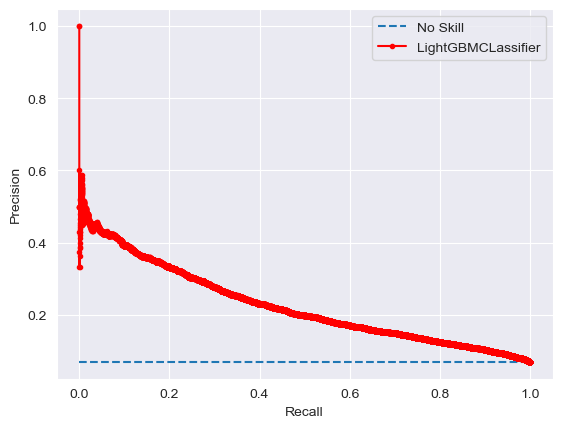

In [63]:
#calculate pr_curve
precision2_b, recall2_b, thresholds_2_b = precision_recall_curve(y_test,  yhat_balance_pos)

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall2_b, precision2_b, marker='.', label='LightGBMCLassifier', color = 'r')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()



In [64]:
best_threshold_pr_curve_b,best_f_b, index_pr_b = tune_thresholds_pr_curve(y_test, yhat_balance_pos)

print('Best Threshold_PR_curve=%f' %(best_threshold_pr_curve_b))

Best Threshold_PR_curve=0.683685


In [65]:
print(fbeta_score(y_train, lgbm_balance.predict(X_train), beta=5))
predicted = lgbm_balance.predict(X_test)
fbeta_score(y_test, predicted, beta=5)

0.6222586825370945


0.607984319917244

[Text(0, 0.5, 'Predict Positive:1'), Text(0, 1.5, 'Predict Negative:0')]

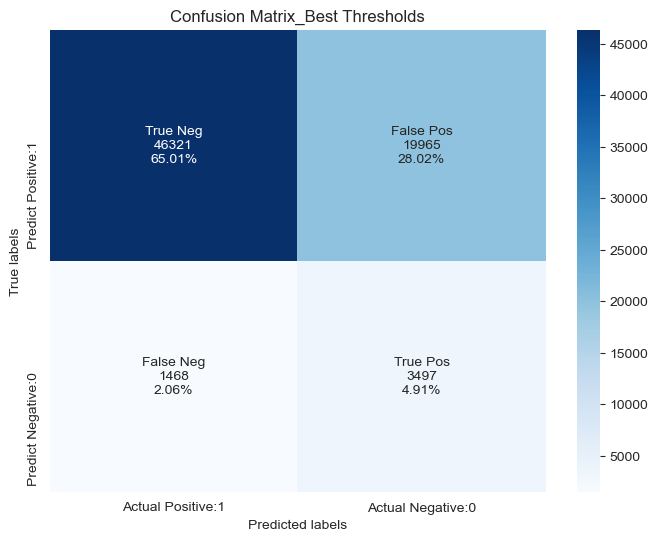

In [66]:
thresh_roc_b =proba_to_class(yhat_balance_pos, best_threshold_b)

cm_b = confusion_matrix(y_test,thresh_roc_b)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_b.flatten()/np.sum(cm_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_b, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_Best Thresholds')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])

In [67]:
print(color.BOLD + color.RED +'Classification Report_Class-weight'+ color.END)
print(classification_report(y_test, thresh_roc_b ))

Classification Report_Class-weight
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81     66286
         1.0       0.15      0.70      0.25      4965

    accuracy                           0.70     71251
   macro avg       0.56      0.70      0.53     71251
weighted avg       0.91      0.70      0.77     71251



# 8. Comparer les modèles 

Resampling with SMOTE
ROCAUC score: 0.6607
Precision score: 0.1249
recall score: 0.6761
F_measure: 0.2109
Fbeta-measure: 0.5780


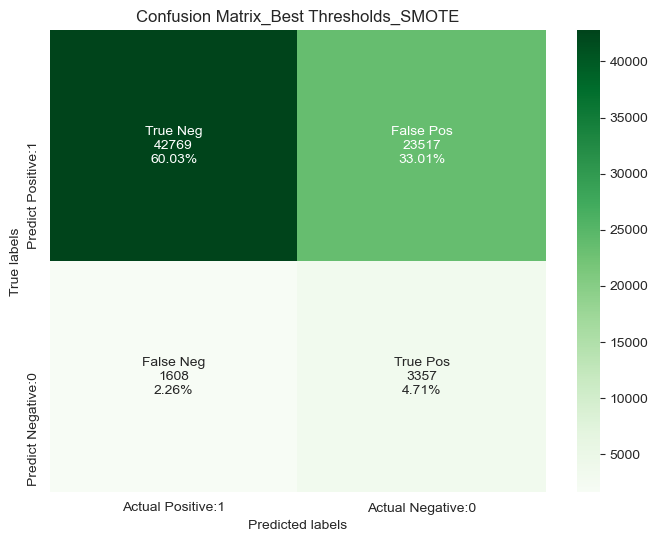

In [68]:
print(color.BOLD + color.RED +"Resampling with SMOTE"+ color.END)


cm_smote = confusion_matrix(y_test,thresh_roc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_smote.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_smote.flatten()/np.sum(cm_smote)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_smote, annot=labels, fmt='', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_Best Thresholds_SMOTE')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])


print('ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, thresh_roc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, thresh_roc)))
print('recall score: {0:0.4f}'.format(recall_score(y_test, thresh_roc)))
print('F_measure: {0:0.4f}'.format(f1_score(y_test, thresh_roc)))
print('Fbeta-measure: {0:0.4f}'.format(fbeta_score(y_test, thresh_roc, beta = 5)))



Resampling with class_weith
ROCAUC score: 0.7690
Precision score: 0.1506
Recall score: 0.6920
F_measure: 0.2474
Fbeta-measure: 0.6080


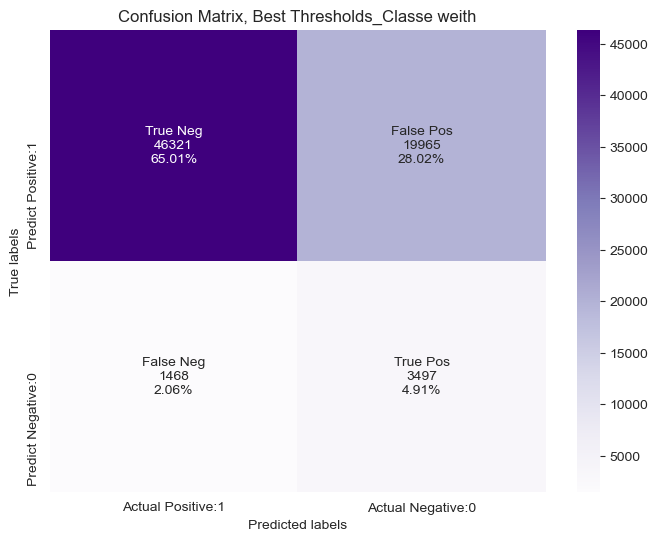

In [69]:
print(color.BOLD + color.BLUE +"Resampling with class_weith"+ color.END)
#cf_matrix_roc_auc(X_train, y_train, best_business_lg_balance)
cm_b = confusion_matrix(y_test,thresh_roc_b)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_b.flatten()/np.sum(cm_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_b, annot=labels, fmt='', cmap='Purples')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix, Best Thresholds_Classe weith')
ax.xaxis.set_ticklabels(['Actual Positive:1', 'Actual Negative:0'])
ax.yaxis.set_ticklabels(['Predict Positive:1', 'Predict Negative:0'])


print('ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, yhat_balance_pos)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test,y_pred_balance)))
print('Recall score: {0:0.4f}'.format(recall_score(y_test, y_pred_balance)))
print('F_measure: {0:0.4f}'.format(f1_score(y_test, y_pred_balance)))
print('Fbeta-measure: {0:0.4f}'.format(fbeta_score(y_test, y_pred_balance, beta = 5)))

In [70]:
cw_aucroc=round(roc_auc_score(y_test, yhat_balance_pos), 3)
cw_f5score = round(fbeta_score(y_test, y_pred_balance, beta = 5),3)


smote_aucroc =round(roc_auc_score(y_test, thresh_roc),3)
smote_f5score = round(fbeta_score(y_test, thresh_roc, beta =5),3)

In [71]:
d = {'AUC_ROC' : [cw_aucroc, smote_aucroc],
    'F5score' : [cw_f5score,smote_f5score]}

comparing_model_df = pd.DataFrame(data=d)
scores = ['class_weight', 'Smote']
comparing_model_df.index = scores
comparing_model_df = comparing_model_df.reset_index()

In [72]:
comparing_model_df=comparing_model_df.rename(columns = {"index" : "Model"})

comparing_model_df

,Model,AUC_ROC,F5score
0,class_weight,0.769,0.608
1,Smote,0.661,0.578


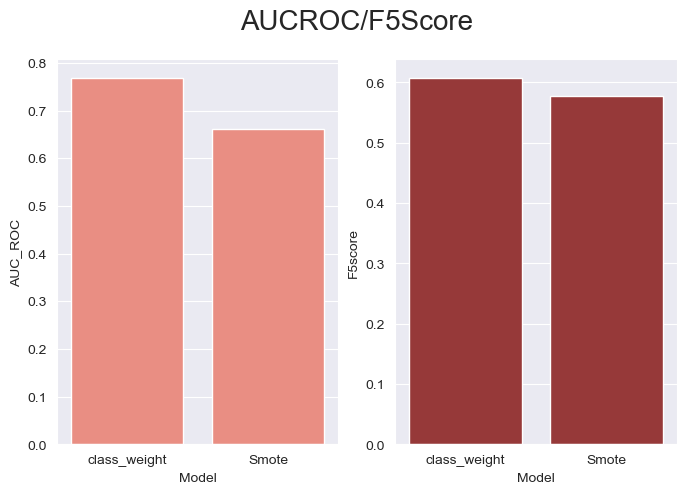

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle("AUCROC/F5Score", fontsize = 20)
sns.barplot(data= comparing_model_df, x= comparing_model_df['Model'], y = comparing_model_df['AUC_ROC'],ax=axes[0], color = 'salmon')
sns.barplot(data= comparing_model_df, x= 'Model', y = 'F5score', ax= axes[1], color = 'brown')
plt.show()

# 9. Enregistrer le modèle sur le disque 


In [74]:
lgbm_balance

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=9,
               random_state=1)

In [75]:
# save the model to disk
filename = 'final_model.sav'
pickle.dump(lgbm_balance, open(filename, 'wb'))

In [76]:
joblib.dump(lgbm_balance, 'lgbm_balance.pkl')

['lgbm_balance.pkl']

# 10. Interprétabilité du modèle 
## 10.1 Interprétabilité globale : feature importance 


In [77]:
## Install eli5
#import sys
#!{sys.executable} -m pip install eli5

#### Permutation feature importance


In [77]:
# Get features' name
features = data_final.drop(columns=['TARGET'],axis=1).columns

In [79]:
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.inspection import permutation_importance

permutation = PermutationImportance(lgbm_balance, random_state=1).fit(X_test, y_test)
eli5.show_weights(permutation, feature_names = features.tolist())


Weight,Feature
0.0053 ± 0.0015,CODE_GENDER
0.0038 ± 0.0010,EXT_SOURCE_2
0.0021 ± 0.0003,PREV_DAYS_DECISION_MIN
0.0020 ± 0.0003,INSTAL_DAYS_ENTRY_PAYMENT_SUM
0.0017 ± 0.0005,FLAG_OWN_CAR
0.0015 ± 0.0015,DAYS_BIRTH
0.0015 ± 0.0007,INSTAL_AMT_PAYMENT_MIN
0.0015 ± 0.0004,NAME_FAMILY_STATUS_Married
0.0008 ± 0.0003,NAME_CONTRACT_TYPE_Cashloans
0.0008 ± 0.0005,PREV_DAYS_DECISION_MEAN


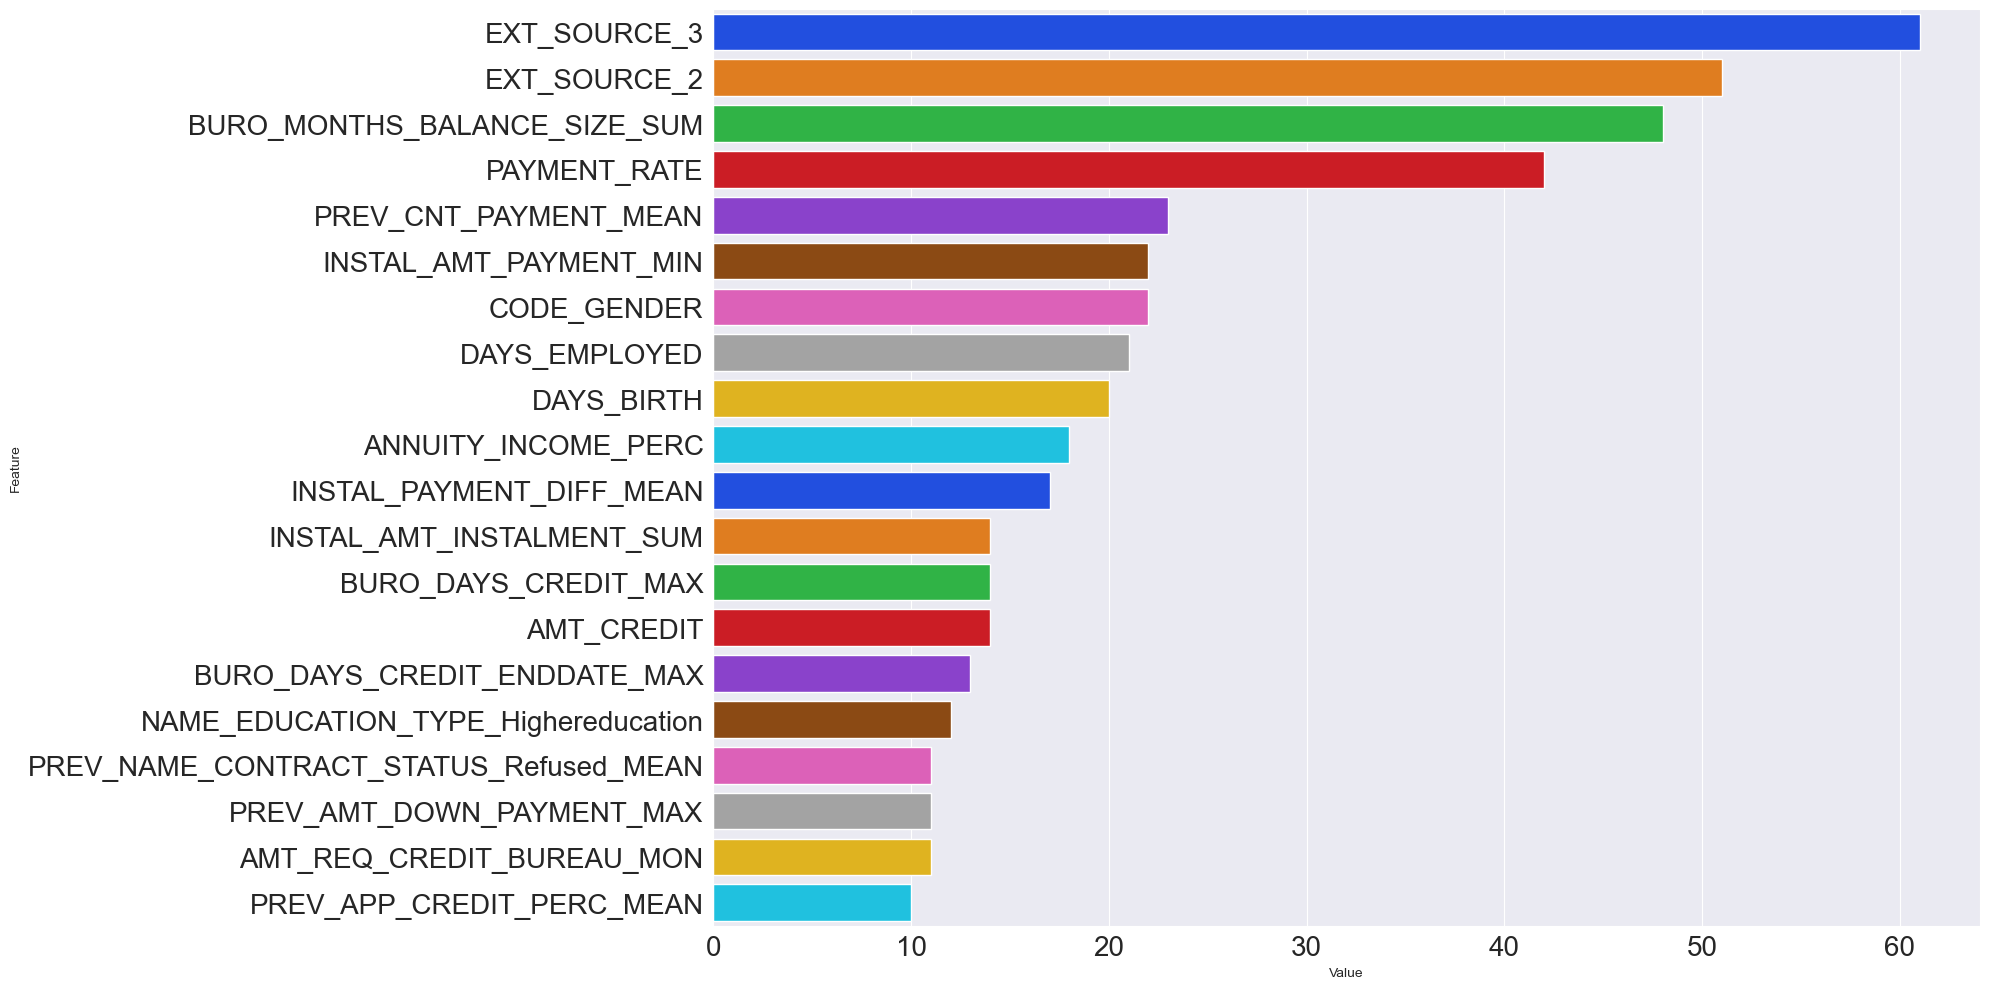

In [84]:
feature_imp_balnace = pd.DataFrame(sorted(zip(lgbm_balance.feature_importances_,features)), 
                                   columns=['Value','Feature'])
feature_imp_balnace = feature_imp_balnace.sort_values(by = 'Value', ascending= False)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data = feature_imp_balnace.iloc[:20,:], palette = 'bright')
#plt.title('LightGBM Features_Classe-WEIGHT (avg over folds)', size=25)
plt.xticks(size=20)
plt.yticks(size=20)

plt.tight_layout()
plt.show()

In [81]:
#feature_importance_export = feature_imp_balnace.head(20).set_index('Feature')

#feature_importance_export.to_csv(r"C:\Users\faeze\OneDrive\Documents\OC data science\PROJECT\Projet 7\feature_imp.csv")

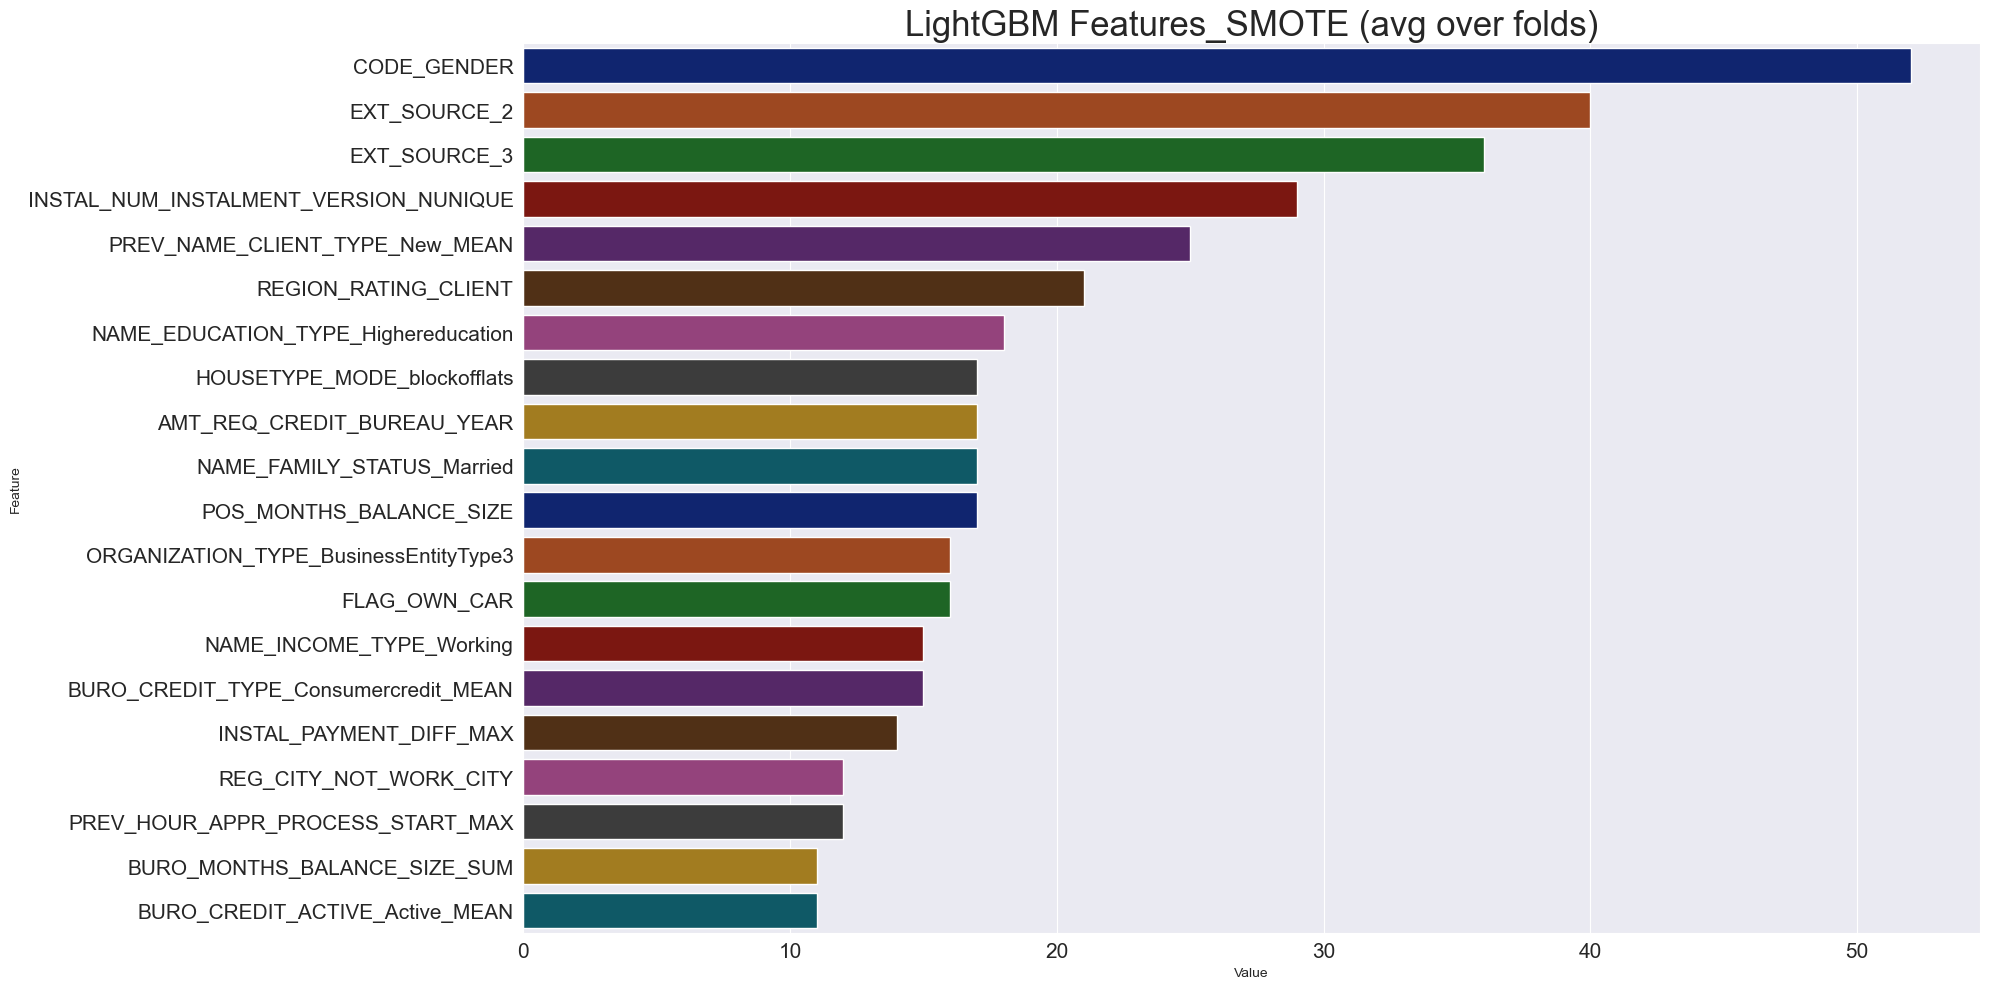

In [79]:
feature_imp_smote = pd.DataFrame(sorted(zip(best_buisness_model_smote.feature_importances_,features)), columns=['Value','Feature'])
feature_imp_smote = feature_imp_smote.sort_values(by = 'Value', ascending= False)


plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_smote.iloc[:20,:], palette = 'dark')
plt.title('LightGBM Features_SMOTE (avg over folds)', size=25)
plt.xticks(size=15)
plt.yticks(size=15)

plt.tight_layout()
plt.show()

## 10.2  Interprétabilité locale : « shaply values » 

In [164]:
#import sys
#!{sys.executable} -m pip install shap

In [165]:
#! pip install --upgrade shap


In [80]:
# To define SHAP explanation object
explainer = shap.TreeExplainer(lgbm_balance)


shap_values_model =explainer.shap_values(X_test)

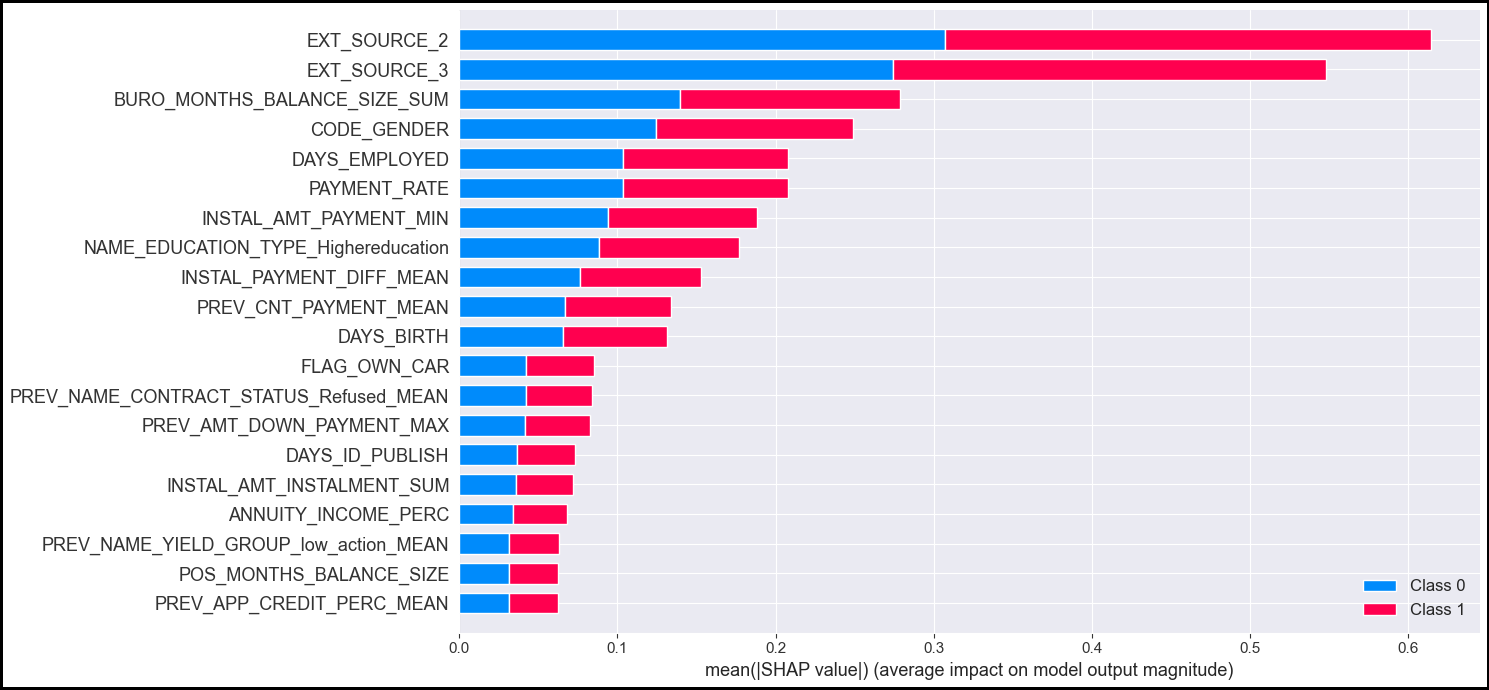

In [81]:
fig = plt.figure(edgecolor='black', linewidth=4)
shap.initjs()
shap.summary_plot(shap_values_model, X_test, feature_names=list(features), max_display=20, 
                  plot_size=(15,7))

- Les feutures sont triées selon leur effet sur la prédiction. 
- Il prend en compte la valeur SHAP absolue, donc peu importe si la variable affecte la prédiction de de classe 1 ou classe 0.
-L’importance des variables est calculée en moyennant la valeur absolue des valeurs de Shap. 

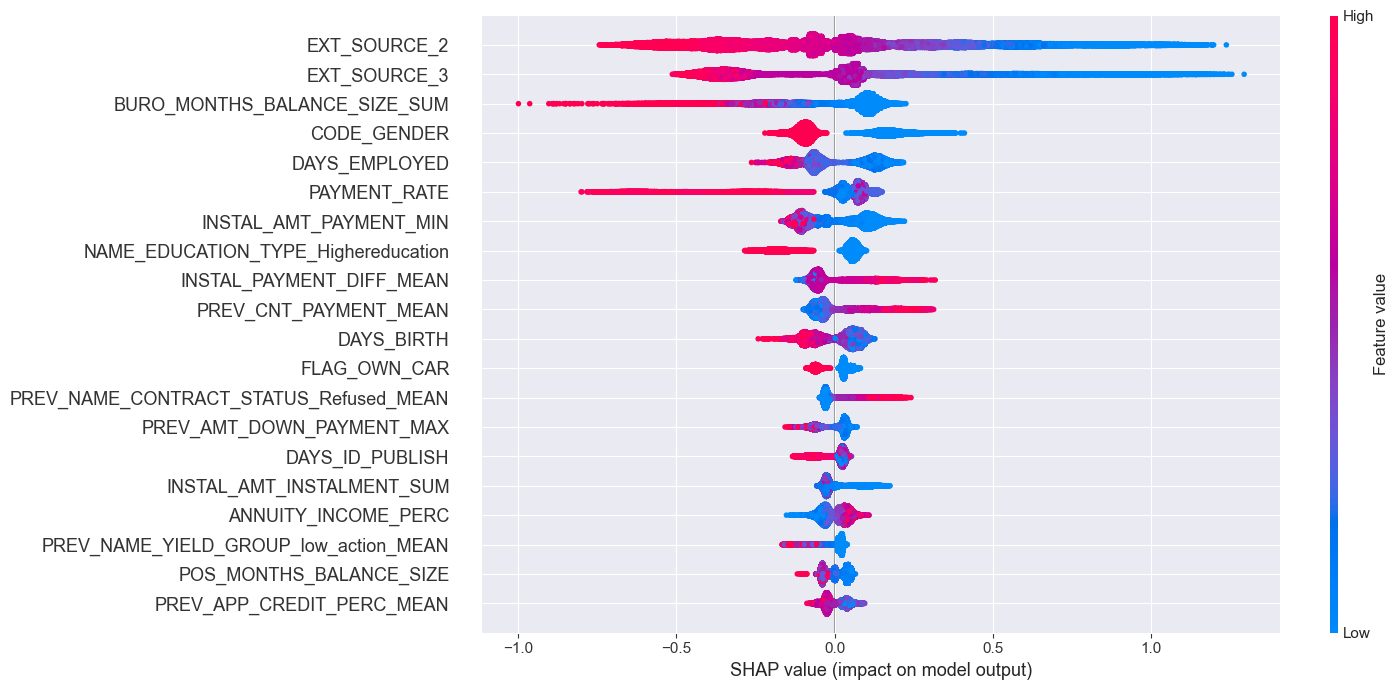

In [82]:
shap.initjs()

shap.summary_plot(shap_values_model[1], X_test, feature_names=list(features), max_display=20, 
                  plot_size=(15,7))

- Les valeurs de Shap sont représentées pour chaque variable dans leur l'ordre d’importance, chaque point représente une valeur de Shap (pour un individu), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable
- On peut voir par exemple pour chaque variable si les SHAPley valeurs sont négatives (situées sur la gauche) donc la varible est en défaveur de la prédiction CLASSE 1.
- Au contraire, pour les point rouge,  les SHAPley valeurs sont positives (situées sur la droite) donc en faveur de la prédiction de la CLASSSE 1.

- Par exemple "external source2" qui est la variable la plus importante, a un impact négatif quand la valeur de cette variable est élevée.

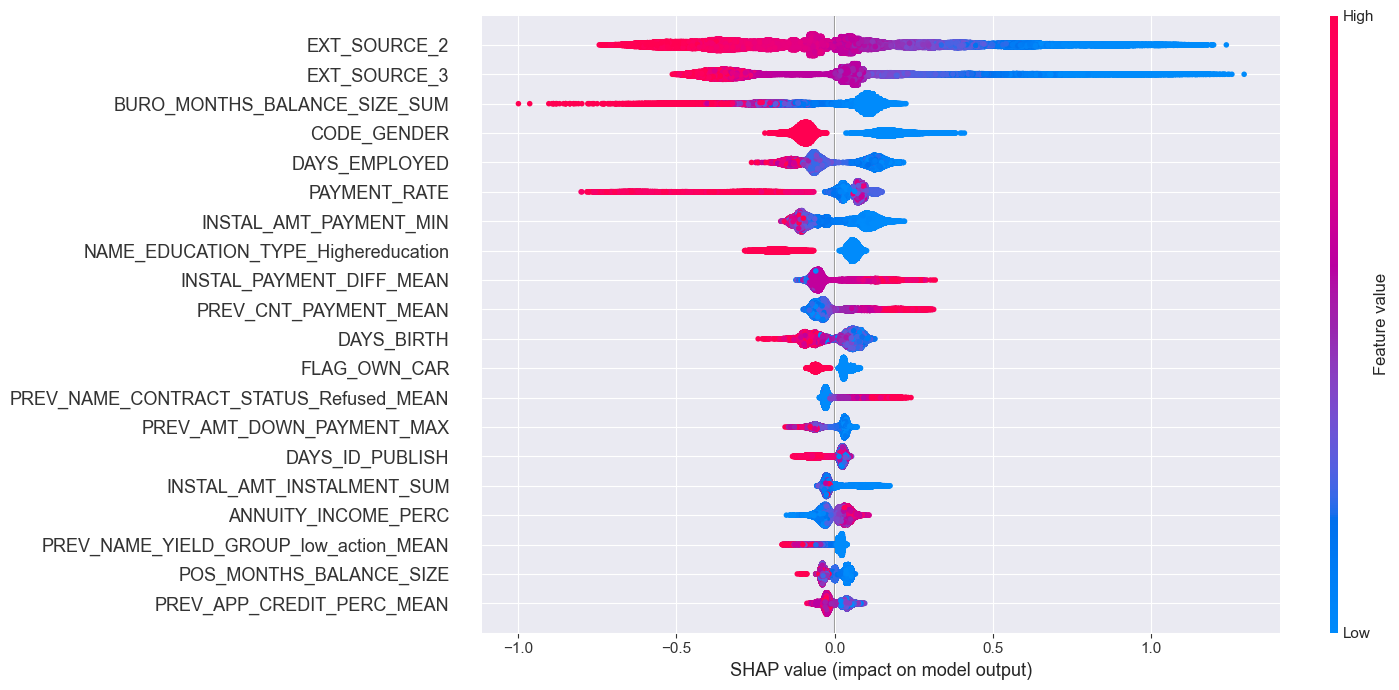

In [83]:
shap.initjs()
shap.summary_plot(shap_values_model[1], X_test, feature_names=list(features), max_display=20, 
                  plot_size=(15,7))

In [86]:
expected_values = explainer.expected_value
if isinstance(expected_values, list):
    expected_values_0 = expected_values[1]
print(f"Explainer expected value: {expected_values_0}")

Explainer expected value: -0.3891357693362993


In [92]:
# Choose a customer id
index_client1 = np.random.randint(0, len(y_test))
shap.force_plot(base_value= expected_values[1],  shap_values = shap_values_model[1][index_client1],link= 'logit',
                                          features=list(features), plot_cmap="PkYg",  figsize=(20, 3)) 

- Le force plot nous montre où se place le «output value» par rapport à la «base value».
- La prédiction de la target est 0.31 et la valeur de base du dataset est à 0.40 (moyenne des valeurs de la target).
- En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit 1) et, en vert, celles ayant un impact négatif (contribuent à ce que la prédiction soit 0).
- Le crédit de cette personne en particulier a été accepté, car elle a été poussée plus haut par tous les facteurs indiqués en vert. 

In [93]:
# Choose a customer id

index_client2 = np.random.randint(0, len(y_test))
shap.force_plot(base_value= expected_values[1],  shap_values = shap_values_model[1][index_client2], link='logit',
                                          features=list(features), plot_cmap="PkYg",  figsize=(20, 3)) 

- Le force plot nous montre où se place le «output value» par rapport à la «base value».
- La prédiction de la target est 0.85 et la valeur de base du dataset est à 0.40 (moyenne des valeurs de la target).
- En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit 1) et, en vert, celles ayant un impact négatif (contribuent à ce que la prédiction soit 0).
- Le crédit de cette personne en particulier a été refusé, car elle a été poussée plus haut par tous les facteurs indiqués en rouge. 


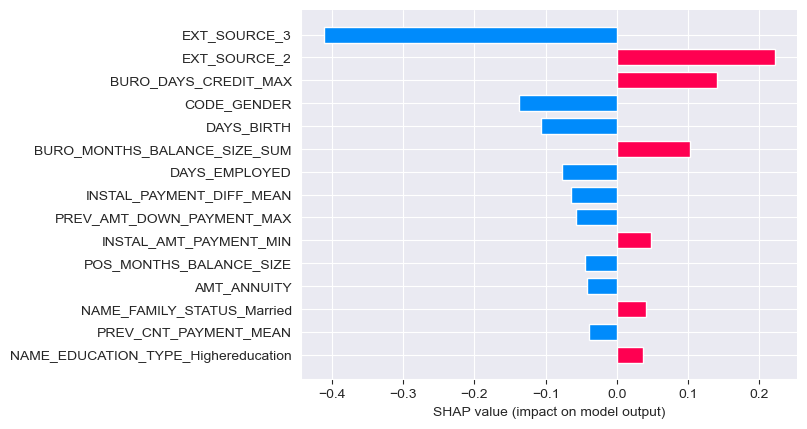

In [94]:
fig = plt.figure()
shap.bar_plot(shap_values_model[1][index_client1],
             feature_names= list(features),max_display = 15,show = False)
plt.yticks(fontsize= 10)
plt.show()

Ce graphique montre quelles sont les principales varaible affectant la prédiction d'une seule observation , et l'ampleur de la valeur SHAP pour chaque variable.

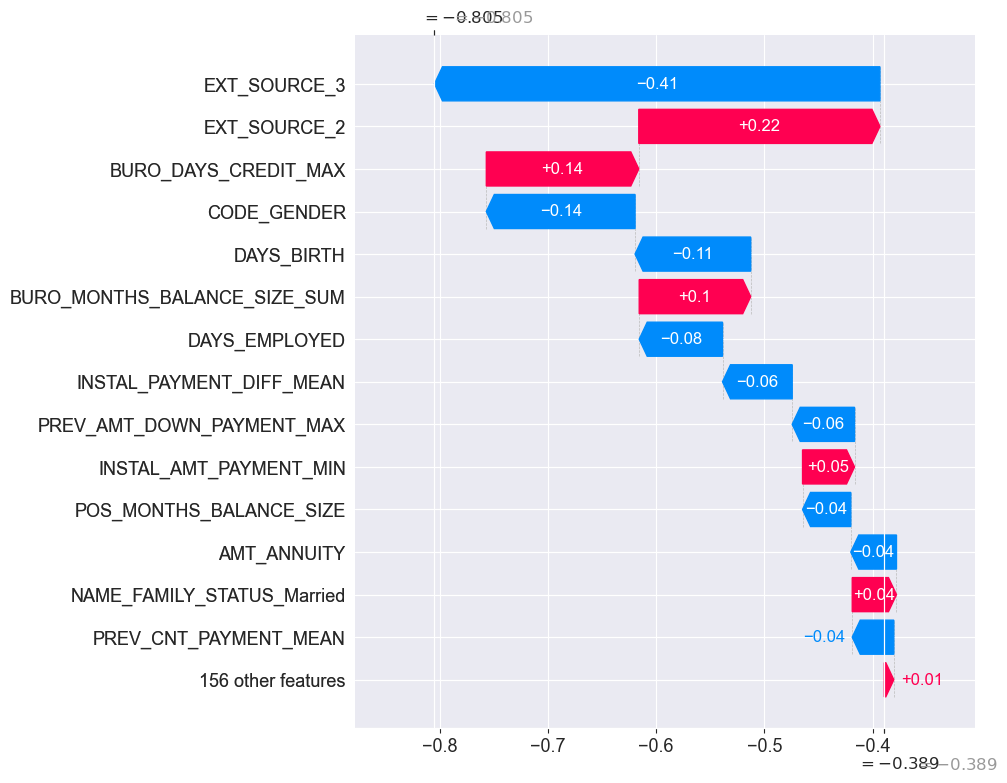

In [95]:
fig = plt.figure()
shap.plots._waterfall.waterfall_legacy(expected_values[1],
                                        shap_values_model[1][index_client1],
                                        feature_names = list(features),
                               max_display = 15, show = False)
plt.yticks(fontsize= 10)
plt.show()

Cette graphqique montre l’impact de chacune des caractéristiques de l’individu choisi et comment ces caractéristiques impactent la prédiction. En bleu les caractéristiques ayant une SHAPley valeur négative donc en faveur du remboursement le prêt et en rouge les caractéristiques ayant une SHAPley valeur positive donc en défaveur du payment du prêt.

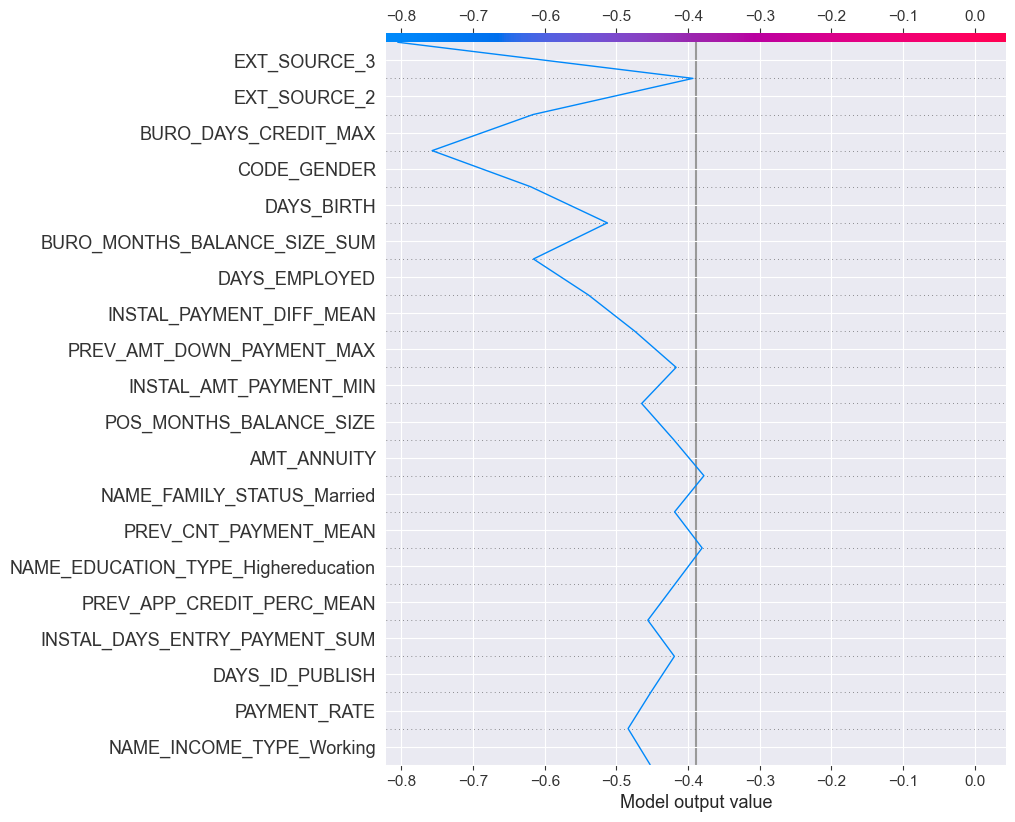

In [96]:
shap.decision_plot(base_value=explainer.expected_value[1],
                                          shap_values=shap_values_model[1][index_client1],
                                          features=list(features),
                                          )

- "Shap force plot" est une autre façon de voir l'effet de chaque varibel sur la prédiction, pour une observation donnée. - - Dans ce graphique, les valeurs SHAP positives sont affichées sur le côté gauche et les valeurs négatives sur le côté droit, comme si elles se faisaient concurrence.
- La valeur en surbrillance est la prédiction pour cette observation.

# END 